OktoberKite - Best So Far (BSF)
===

Represents the current best model / understanding of the OktoberKite effort.

This copy branched from the OktoberKite - Best So Far (BSF) on 5/5/20, which was itself branched from [4.5 SHARED](https://colab.sandbox.google.com/drive/1IuVv7ysResOtXBLpJ3kyaE7L_O0F60ZV) on 11/22/19.
And then branched from the Py2 version early 2020.


>[OktoberKite - Best So Far (BSF)](#scrollTo=FxauQE5vUyT3)

>[Instructions](#scrollTo=nxDfnay8kFMf)

>[Setup and Import blocks](#scrollTo=NrawFtaQkfnz)

>[Setup config options and environment](#scrollTo=HJLDKnoPpugL)

>[Set up kite configs](#scrollTo=p4h6YoWw-kD-)

>[Set up the study](#scrollTo=H08zGTs6sQp5)

>[Solve Power Curves](#scrollTo=CxQ6T9Hfcw7q)

>[Plot Results and Export](#scrollTo=hQyp45JEinEx)

>>[Explore Plots](#scrollTo=y6ZA7RNi_WWv)

>[Load in params and regenerate power_curve objects](#scrollTo=60wHeRvvh2wj)

>[Deprecated/Draft](#scrollTo=AxKRBj_MuU4o)



# Instructions



1.  Start a local jupyter server runtime **in your mx_sys folder**

```
jupyter notebook --NotebookApp.allow_origin='https://colab.sandbox.google.com' --port=8888 --NotebookApp.port_retries=0
```
2.  Connect this Colab notebook (make a copy if you haven't already) to that local runtime.
3.  Update your path to the FBL results folder in the 'Set default output folders' section
4.  Run the setup cells, make new kite configs as needed.
5.  Either create a power curve by optimizing a config and path, or load in prior results and regenerate the power curve

Other notes:
  - Naming convention allows underscores, but not the hyphen '-' as part of kite names, path names, or figure names. 
  - There are breaks in the code so that you do not accidentally run several different types of power curves. 
  - User names for File stream need to be changed manually.

General Colab tips @ [go/makani-colab](https://goto.google.com/makani-colab)

---


[Full instructions](https://research.google.com/colaboratory/local-runtimes.html) for colab runtime setup (but instead of using colab.research, use colab.sandbox (Google recognizes we're internal and redirects us.)

Note: first time only, you may need to install and enable the jupyter_http_over_ws jupyter extension: 

  - `pip3 install jupyter_http_over_ws`

  - `jupyter serverextension enable --py jupyter_http_over_ws`

You should also set up drive file stream so you can import/export to the shared results folders.

  - [go/drive-fs](http://go/drive-fs)
  - see the [go/drive-fs-linux](http://go/drive-fs-linux) section for linux.



# Setup and Import blocks

In [ ]:
#@title Python import block

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import numpy as np
import os
import scipy
import math
import json
from pprint import pprint as pp
import time
import copy
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from cycler import cycler
import itertools
import pandas as pd
import cProfile
import csv
import inspect
import IPython
import numbers

import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../')

os.getcwd()


'/Users/ntucker/Documents'

In [ ]:
#@title FBL import block

#@markdown rerun this cell if you've made any FBL code changes or pulled a new branch

sys.path.insert(0, 'Code/mx_modeling/')

from power_calcs import power_calcs as makani_FBL
from power_calcs import kite_pose
from power_calcs import kite_loop
from power_calcs import kite_path
from lib import utils
from lib import fun

from tools import m600_fbl_config_manager as configs
from tools import resource_fbl_manager as resources
from tools import rotor_model_util

import six
from six.moves import zip

import sys
python_version = sys.version[0]
if python_version == '3':
  import importlib
  importlib.reload(makani_FBL)
  importlib.reload(configs)
  importlib.reload(rotor_model_util)
  importlib.reload(resources)
  importlib.reload(kite_pose)
  importlib.reload(kite_path)
  importlib.reload(kite_loop)
  importlib.reload(utils)
  importlib.reload(fun)
elif python_version == '2':
  reload(makani_FBL)
  reload(configs)
  reload(rotor_model_util)
  reload(resources)
  reload(kite_pose)
  reload(kite_path)
  reload(kite_loop)
  reload(utils)
  reload(fun)

import datetime
import pytz


In [ ]:
#@title Plotting utils def block { form-width: "20%" }

default_figsize = (6,5)

path_params_to_plot = {
    'circle': ['azim_avg_dist', 'incl_avg_dist', 'r_loop'],
    'f8_hermite': [
        'azim_avg_dist', 'incl_avg_dist', 'slope', 'lobe_d', 'asymmetry',
        'sharpness', 'centroid_sharpness_ratio', 'keystone_angle', 'tilt'
    ],
    'dir_harmonics': [
        'azim_avg_dist', 'incl_avg_dist', 'base_radius'
    ],  # 'amp2', 'phase2', 'amp3', 'phase3', 'amp4', 'phase4'], # need to add these params to self directly at ~line 595 of kite_path, so that they are accessible to this plotter...
}

def plot_aero_moment_breakdown(pc):
  # Calculate data
  for loop in pc.loops:
    for pose in loop.poses:
      for m in ['cl', 'cm', 'cn']:
        pose.state[m + '_rates_0'] = [0., 0., 0.]
        pose.state[m + '_ab_0'] = (
            pc.config['body_coeff_from_alpha_beta'](
              pose.state['alpha'], pose.state['beta'], [0., 0., 0.])[m])
        for ii, o in enumerate(['p', 'q', 'r']):
          o_hat = copy.deepcopy(pose.state['omega_hat'])
          o_hat[ii] = 0.
          pose.state[m + '_rates_0'][ii] = (
              pose.state[m]
              - pc.config['body_coeff_from_alpha_beta'](
                  pose.state['alpha'], pose.state['beta'], o_hat)[m])
    loop._extract_pose_data()
  # Plot data
  figs = {}
  for m in ['cl', 'cm', 'cn']:
    figs[m + '_breakdown'] = pc.plot_vectors(
      ys=[m + '_rates_0'], figsize=default_figsize,
      ys_components=[[six.ensure_str(m)+'_p', six.ensure_str(m) + '_q', six.ensure_str(m) + '_r']],
      every_nth=2)
    figs[m + '_breakdown'] = pc.plot_pose_data(
      ys=[m + '_ab_0'], fig=figs[six.ensure_str(m) + '_breakdown'],
      base_label=six.ensure_str(m) + '_alpha_beta_0 ',
      plot_kwargs={'linestyle':(0, (3,1,1,1,1,1,1,1))},
      every_nth=2)

    figs[m + '_breakdown'] = pc.plot_pose_data(
      ys=[m], fig=figs[six.ensure_str(m) + '_breakdown'],
      plot_kwargs={'linewidth':0.5, 'marker': 'o', 'markersize':2},
      base_label=six.ensure_str(m) + '_total ',
      every_nth=2)
    figs[m + '_breakdown'].gca().set_title(m + ' Component Breakdown')
  return figs

def PlotPowerCurveData(pc, **kwargs):
  figsize = kwargs.get('figsize', default_figsize)
  every_nth = kwargs.get('every_nth', 2)
  plots = kwargs.get('plots', 'all')
  pose_wrap_x = kwargs.get('pose_wrap_x', None)

  data_figs = {}

  if plots=='all' or 'power_curve' in plots:
    data_figs['power_curve'] = pc.plot_power_curve(figsize=figsize)
  if plots=='all' or 'paths_locations' in plots:
    data_figs['paths_locations'] = pc.plot_paths(
        with_azim_incl=True, figsize=figsize, every_nth=every_nth)
  if plots=='all' or 'loop_data' in plots:
    loop_data_ys = [
        'power_avg_time', 'zeta_padmount_avg_time', 'tension_avg_time',
        'v_a_avg_time', 'total_time']
    loop_data_ys.extend(
        path_params_to_plot[pc.path_shape_params_output[0]['type']])
    data_figs['loop_data'] = pc.plot_loop_data(ys=loop_data_ys, figsize=figsize)
  if plots=='all' or 'pose_data' in plots:
    pose_data_ys = [
        'tension',
        'power',
        'v_a',
        'v_k',
        'alpha',
        'beta',
        'cL',
        'cD',
        'cL_over_cD_sys',
        'cY',
        'cl',
        'cm',
        'cn',
        'r_curv',
        'tether_pitch_angle',
        'tether_roll_angle',
        'lift_roll_angle',
        'lift',
        'drag_kite',
        'side_lift',
        'rotor_force',
        'k_rotor_drag_frac',
        'k_grav',
        'eta_rotors',
        'c_p',
        'c_t',
        'adv_ratio',
        'omega_rotor',
        'tip_mach',
        'torque_shaft',
        'eta_shaft_to_pad'
    ]
    if 'aero_device' in pc.config:
      pose_data_ys.insert(5, 'aero_device_scale')
    data_figs['pose_data'] = pc.plot_pose_data(
        ys=pose_data_ys, figsize=figsize, every_nth=every_nth, wrap_x=pose_wrap_x)
  if plots=='all' or 'angular_rates' in plots:
    data_figs['angular_rates'] = pc.plot_vectors(
        ys=['omega_hat', 'pqr', 'pqr_dot'],
        ys_components=[['p', 'q', 'r']],
        every_nth=every_nth, figsize=figsize)
  if plots=='all' or 'rotor_map' in plots:
    data_figs['rotor_map'] = pc.plot_rotor_map(
        every_nth=every_nth, figsize=figsize)
  if plots=='all' or 'moments_b_xyz' in plots:
    data_figs['moments_b_xyz'] = pc.plot_vectors_components(
        ys=[['moments_b', 'type', t] for t in
            ['rotors', 'aero', 'tether', 'inertial', 'gravity', 'residual']],
        y_components=['x', 'y', 'z'],
        ys_labels=['m_rotors', 'm_aero', 'm_tether', 'm_inertial', 'm_gravity',
                  'm_residual'],
        every_nth=every_nth, figsize=figsize,
        # ylims='equal',
    )
  if plots=='all' or 'flap_aero_coeffs' in plots:
    data_figs['flap_aero_coeffs'] = pc.plot_vectors(
        ys=['flap_aero_coeffs'],
        ys_components=[['cl', 'cm', 'cn']],
        every_nth=every_nth, figsize=figsize)
  if plots=='all' or 'aero_moment_breakdown' in plots:
    data_figs.update(plot_aero_moment_breakdown(pc))
  if plots=='all' or 'constraints_final' in plots:
    data_figs['constraints_final'] = (
        pc.plot_constraints(
            figsize_constraints_h=figsize[0],
            figsize_constraints_v=figsize[1],
            figsize_path=(6,6))['constraints'])
  return data_figs

def PlotAeroModels(kite_name, config, aero_models):
  aero_figs = {}
  if kite_name in aero_models:
    aero_figs = configs.PlotKiteAero(
        config,
        keys=['zeta', 'L/D', 'cL', 'cD', 'cY', 'cl', 'cm', 'cn'],
        alpha_linspace=(-10., 10., 30),
        omega_hat=aero_models[kite_name]._bomega_hat_0,
        figsize=default_figsize, levels=25)
    if 'L/D' in aero_figs:  # can't use '/' in exported file name
      aero_figs['L_over_D'] = aero_figs['L/D']
      del aero_figs['L/D']
    elif 'cL' in aero_figs: # can't have lower/upper case duplicates
      aero_figs['cL_lift'] = aero_figs['cL']
      del aero_figs['cL']
  else:
    print('{} kite has no corresponding entry in aero_models ({}).'.format(
        kite_name, list(aero_models.keys())))

  return aero_figs


def plot_power_curve(pc,
                     v_ws_h_type='both',
                     power_type='both',
                     plot_kwargs={},
                     **kwargs):
  figsize = kwargs.get('figsize', default_figsize)
  fig = kwargs.get('fig', None)
  plot_kwargs['label'] = plot_kwargs.get('label', '')
  base_label = plot_kwargs['label']
  if not fig:
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
  ax = fig.get_axes()[0]

  ax.set_title('Power Curve')
  ax.set_xlabel('v_w [m/s]')
  ax.set_ylabel('padmount power [W]')
  if v_ws_h_type in ['ref', 'both'] and power_type in ['all', 'both']:
    plot_kwargs['label'] = six.ensure_str(base_label) + ' @ h_ref'
    ax.plot(pc.v_ws_at_h_ref, pc.powers, ':', **plot_kwargs)
  if v_ws_h_type in ['hub', 'both'] and power_type in ['all', 'both']:
    plot_kwargs['label'] = six.ensure_str(base_label) + ' @ h_virt_hub'
    ax.plot(pc.v_ws_at_h_hub, pc.powers, ':', **plot_kwargs)
  if v_ws_h_type in ['ref', 'both'] and power_type in ['valid', 'both']:
    plot_kwargs['label'] = six.ensure_str(base_label) + ' @ h_ref, valid'
    ax.plot(pc.v_ws_at_h_ref, pc.powers_valid, **plot_kwargs)
  if v_ws_h_type in ['hub', 'both'] and power_type in ['valid', 'both']:
    plot_kwargs['label'] = six.ensure_str(base_label) + ' @ h_virt_hub, valid'
    ax.plot(pc.v_ws_at_h_hub, pc.powers_valid, **plot_kwargs)
  ax.axhline(linewidth=1, label=None)
  ax.grid(linewidth=0.5, linestyle=':')
  ax.legend()
  ax.set_xticks(np.arange(0, 25, 2.5))

  plt.grid(b=True, which='major', color='#666666', linestyle='-')

  # Show the minor grid lines with very faint and almost transparent grey lines
  plt.minorticks_on()
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

  return fig


def compare_power_curves(pcs, export_name=None, export_path=None, **kwargs):
  figsize = kwargs.get('figsize', (12, 9))
  dpi = kwargs.get('dpi', 100)
  fig, ax = plt.subplots(figsize=figsize)
  # colors = ['black', 'blue', 'red']
  colors = utils.set_rainbow_plot_cycler(n=len(pcs), ax=ax)
  ax.set_prop_cycle(cycler('linestyle', ['-', '--', '-.', ':']))
  #colors = []
  #cstart = 0.3
  n_paths = 1
  #colors.extend([cm.Blues(x) for x in np.linspace(cstart, 1., n_paths)])
  #colors.extend([cm.Reds(x) for x in np.linspace(cstart, 1., n_paths)])
  #colors.extend([cm.Greens(x) for x in np.linspace(cstart, 1., n_paths)])
  for ii, k in enumerate(sorted(pcs.keys())):
    plot_power_curve(
        pcs[k],
        fig=fig,
        v_ws_h_type='ref',
        power_type='valid',
        plot_kwargs={
            'label': k,
            'color': colors[ii],
            'linewidth': 2.5
        })
    
  # Data for M600 Spec PowerCurve
  # M600-B-SP29 'pilot ready' from ProgramWithCorrections, 0.0 shear.
  # https://docs.google.com/spreadsheets/d/1WmnZ8J3DPl7Q9AqqwM2yJYv2bNyQnopwSz0xmZqb-pU/edit
  x = [4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10, 10.25, 10.5, 10.75, 11, 11.25, 11.5, 11.75, 12, 12.25, 12.5, 12.75, 13, 13.25, 13.5, 13.75, 14, 14.25, 14.5, 14.75, 15, 15.25, 15.5, 15.75, 16, 16.25, 16.5, 16.75, 17, 17.25, 17.5, 17.75, 18, 18.25, 18.5, 18.75, 19, 19.25, 19.5, 19.75, 20]
  y = [6350, 21191.1, 37269.6, 55045.4, 74470.4, 95640.3, 118593.7, 143377.9, 170032.8, 198612, 229085.9, 261678.7, 295601.4, 330081.9, 364908, 399636.1, 434131.2, 468288.4, 501595.1, 535305.7, 564175, 587783.2, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000, 600000]

  y_2 = [
      0.0, 0.0, 0.0, 0.0, 6757.053475650504, 114771.8486127329,
      259933.31972396804, 442845.94193103915, 636632.2789255212,
      789871.1910392254, 900493.1944323677, 983036.8097278756,
      999263.0337276894, 1001080.675274035, 1002676.903301015,
      1002273.6552189812, 998770.084480854, 996293.6003376105,
      968120.0648965053, 942217.4114750661, 923835.2549948797,
  ]

  x_2 = [
      0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0,
      14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0,
  ]
  plt.plot(x, y, 'k:', label='m600 spec')  #,'color',colors[ii+1])
  plt.plot(x_2, y_2, 'k--', label='Spec H')  #,'color',colors[ii+2])
  ax.set_xlim((0., None))
  plt.legend(prop={'size':9})

  if export_path is not None and export_name is not None:
    if not six.ensure_str(export_name).endswith('.png'):
      export_name += '.png'
    fig.savefig(
        os.path.join(export_path, export_name), bbox_inches='tight', dpi=dpi)
    print('{} successfully exported'.format(export_name))
  # ax = plt.gca()
  # ax.set_xticks(np.arange(0,25,2.5))

  # plt.grid(b=True, which='major', color='#666666', linestyle='-')

  # # Show the minor grid lines with very faint and almost transparent grey lines
  # plt.minorticks_on()
  # plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

  return fig


plot_order = [
    'power_curve', 'paths_locations', 'path_loop_data', 'loop_data',
    'angular_rates', 'flap_aero_coeffs', 'moments_b_xyz', 'rotor_map', 'zeta', 'L_over_D',
    'cL', 'cD', 'cY', 'cl', 'cm', 'cn', 'pose_data', 'constraints_final',
    'paths', 'values', 'constraints'
]


In [ ]:
#@title FBL utils def block { form-width: "20%"}

def OptimizePowerCurves(kites, opt_params, pc_suffix='',
                        plot_convergence=True, **kwargs):
  pcs = kwargs.get('pcs', {})
  pc_figs = kwargs.get('pc_figs', {})
  verbose = kwargs.get('verbose', True)
  v_w_at_h_ref_range = kwargs.get('v_w_at_h_ref_range', (7., 14.))
  v_w_step = kwargs.get('v_w_step', 3)
  plot_kwargs = kwargs.get('plot_kwargs', {})
  num_pos = kwargs.get('num_pos', 18)
  # num_spline = kwargs.get('num_spline', 6)
  vars_to_opt = kwargs.get('vars_to_opt',
                           {'lift_roll_angle': {'param_type': 'each',
                                     'values': [-0.1]*num_pos,
                                     'max_step': -0.1},
                  'beta': {'param_type': 'constant',
                          'values': -2.5,
                          'max_step': 1.}
                 })
  path_type = kwargs.get('path_type', 'circle')
  path_shape_params = kwargs.get('path_shape_params', {
        'num_pos': num_pos,
        'type': path_type,
    })
  path_type = path_shape_params['type'] # ensure it matches in case a path_shape_params was passsed
  # add other checks against passing conflicting params?
  if len(pc_suffix)>0 and not six.ensure_str(pc_suffix).startswith('-'):
    pc_suffix = '_'+six.ensure_str(pc_suffix)

  for kite, config in kites.items():
    pc_name = '{}-{}{}'.format(kite, path_type, pc_suffix)
    print()
    print('####################################################################')
    print('Optimizing {}'.format(pc_name))
    pcs[pc_name] =  makani_FBL.KitePowerCurve(resource, config,
      v_w_at_h_ref_range=v_w_at_h_ref_range, v_w_step=v_w_step,
      opt_params=opt_params,
      verbose=verbose,
      vars_to_opt=vars_to_opt,
      path_shape_params=path_shape_params)
    pcs[pc_name].solve()

    pc_figs[pc_name] = {}
    if plot_convergence:
      pc_figs[pc_name].update(pcs[pc_name].plot_convergence_data(
          figsize_values_h=default_figsize[0],
          figsize_values_v=default_figsize[1],
          figsize_path=default_figsize,
          figsize_constraints_h=default_figsize[0],
          figsize_constraints_v=default_figsize[1],
      ))

    # remove convergence data for smaller memory usage
    for ii, _ in enumerate(pcs[pc_name]['loops']):
      del pcs[pc_name]['loops'][ii].convergence_data

  # print summary
  for pc_name, pc in pcs.items():
    print()
    print(pc_name)
    print(pc.solve_summary)

  return pcs, pc_figs

def ExportFigsData(pcs, pc_figs, export_path=None, pc_desc='',
                   export_type='all', pc_comp_name=None, dryrun=True, **kwargs):
  dpi = kwargs.get('dpi', 150)

  json_names = [six.ensure_str(pc_name)+'.json' for pc_name in pcs]
  figs_names = [['{}-{}.png'.format(pc_name, fig_name) for fig_name in pc_figs[pc_name]] for pc_name in pcs]
  all_names = []
  if export_type in ['all', 'data']:
    all_names.extend(json_names)
  if export_type in ['all', 'figs']:
    all_names.extend([fig_name for fig_names in figs_names for fig_name in fig_names])

  print('Exporting results to: {}'.format(export_path))
  if os.path.exists(export_path):
    files_to_overwrite = [name for name in all_names if name in os.listdir(export_path)]
    print('Power curve results to overwrite:')
    pp(files_to_overwrite)
  else:
    print('Creating new folder, nothing to overwrite: rerun w/ overwrite_check set to complete export.')
    os.mkdir(export_path)
  if dryrun:
    print('Aborting export: rerun w/ dryrun set to false to confirm overwriting of any existing files.')
    return

  # Export JSONS w/ path/pose params needed to quickly recreate powercurve
  for (k, pc), json_name, fig_names in zip(six.iteritems(pcs), json_names, figs_names):
    print('Exporting {}'.format(k))
    if export_type in ['all', 'data']:
      kite_name = six.ensure_str(k).split('-')[0]
      if kite_name not in ['base', 'dragflaps']:
        sheet_override = [sheet_override for sheet_override in sheet_overrides if sheet_override['name']==kite_name][0]
      else:
        sheet_override = {}
      export_datetime = datetime.datetime.now(tz=pytz.timezone("America/Los_Angeles"))
      recent_log = !git log --pretty=oneline -n 20
      params = {'pose_states_param': pc.pose_states_param_output,
                  'path_shape_params': pc.path_shape_params_output,
                  'path_location_params': pc.path_location_params_output}
      pc_out = {'export_datetime': export_datetime.isoformat(),
                'pc_desc': pc_desc,
                'loop_params': fun.nested_dict_strip_to_json(params),
                'opt_params': pc.opt_params,
                'solve_summary': pc.solve_summary,
                'config': fun.nested_dict_strip_to_json(pc.config), # full config is not json serializable...
                'kite_name': kite_name,
                'sheets_override': sheet_override,
                'resource': fun.nested_dict_strip_to_json(pc.resource),
                'recent_stackup': recent_log,
                'username': username,
                }
      wind_params = {'v_ws_at_h_ref': pc.v_ws_at_h_ref}
      wind_params['v_w_step'] = np.mean(np.diff(wind_params['v_ws_at_h_ref']))
      wind_params['v_w_at_h_ref_range'] = (
          wind_params['v_ws_at_h_ref'][0],
          wind_params['v_ws_at_h_ref'][-1] + wind_params['v_w_step']/2.)
      pc_out['wind_params'] = wind_params

      with open(os.path.join(export_path, json_name), 'w') as f:
          json.dump(pc_out, f)
      print('{} exported successfully'.format(json_name))

    if export_type in ['all', 'figs']:
      for (kfig, fig), fig_name in zip(list(pc_figs[k].items()), fig_names):
        try:
          fig.savefig(os.path.join(export_path,fig_name),
                      bbox_inches='tight', dpi=dpi)
          print('{} exported successfully'.format(fig_name))
        except:
          print('{} export FAILED'.format(fig_name))
          pass

  print('Export complete')
  return


In [ ]:
#@title Setup opt_params options
#@markdown Also sets optimizer penalties for flap deflections.
opt_params_accurate = {
    'maxiter': 8000,
    'tol': 0.001,
    'catol': 0.01,
    'constraint_stiffness': 0.01,
    # 'flap_m_mult': [1./0.031, 1./0.45, 1./0.025], # BigM600, using the latest MAC def
    'flap_m_mult': [1./0.089, 1./0.94, 1./0.065], # TLG, using the full design intent range of +/- 10, 20, 20 deg on ail, fin, stab
    'flap_penalty_factor': 3.}
opt_params_fast = {
    'tol': 0.05,
    'constraint_stiffness': 0.5,
    'maxiter': 2000}
# Test is used to just do a few iterations.
opt_params_test = {
    'maxiter': 1}


In [ ]:
#@title Set up output folders { form-width: "20%" }

username = 'ntucker' #@param {type:"string"}

#@markdown Set path to your local drive filestream directory. Can select defaults based on system or enter custom.

system = 'mac' #@param ['cloudtop', 'local linux', 'windows', 'mac']
base_paths = {
    'cloudtop':'/usr/local/google/home/{}/DriveFileStream/Shared drives/Makani_FBL/'.format(username),
    'local linux': '/home/{}/DriveFS/Shared drives/Makani_FBL/'.format(username), \
    'windows': 'G:\Shared drives\Makani_FBL',
    'mac': '/Volumes/GoogleDrive/Shared drives/Makani_FBL/'}
base_path = base_paths[system]

#@markdown set export sub-folder
#@markdown (We won't consider anything in 20190821_PracticeTrials 'trustworthy' - feel free to dump stuff here as a trial w/o worrying about overwriting something important)
study_name = 'FOR_RELEASE' #@param {type:"string"}

# for 3D plotly plot maker
plot_dir = os.path.join(base_path, 'PlotlyPlots')
# for power curves
pc_dir = os.path.join(base_path, 'PowerCurves')

pcs_subdir = os.path.join(pc_dir, study_name)
print('Power curve outputs will be saved in:')
print(pcs_subdir)


Power curve outputs will be saved in:
/Volumes/GoogleDrive/Shared drives/Makani_FBL/PowerCurves/FOR_RELEASE


# Setup config options and environment




In [ ]:
#@title Init kite, bridle, and aero dicts
reset_all = True #@param {type:"boolean"}
if 'kites' not in dir() or reset_all:
  kites = {}
if 'bridle_models' not in dir() or reset_all:
  bridle_models = {}
if 'aero_models' not in dir() or reset_all:
  aero_models = {}


In [ ]:
#@title Set up resource  { vertical-output: true, form-width: "50%" }
resource = resources.MakeResourceByShearAndHref(0., 80.)
print('Resource:')
pp(resource)


Resource:
{'c_sound': 343.0,
 'get_v_w_prob_dist': <function get_v_w_prob_dist at 0x7fbc5378baa0>,
 'rho': 1.225,
 'shear': 0.0,
 'v_w_at_height': <function v_w_at_height at 0x7fbc5378bb90>,
 'v_w_avg_h_ref': 7.5}


# Set up kite configs
Notes on setting up new configs:
- Pull in the override dict from the sheet.
- It will not let you step on a kite that already exists in current runtime, you must manually delete that entry.

In [ ]:
#@title Load in Sheet Overrides {form-width: "30%" }

#@markdown Each item in list of sheet overrides should be copied over from here:  
#@markdown
#@markdown https://docs.google.com/spreadsheets/d/1y-3uqpverp79dN5NyLJh8lHnzdAZqpk26XH1WhVcJNU/edit
#@markdown
#@markdown

sheet_overrides = [
    {'name':'YM600_r01_v01', 'alpha_max':4.0000, 'alpha_min':-3.0000, 'beta_max':5.0000, 'beta_min':-5.0000, 'gs_position':[0., 0., 15.], 'incl_max':1.1000, 'bridle_y_offset':-0.5000, 'bridle_radial_length':4.7860, 'power_shaft_max':1208000.0000, 'rotor_mach_limit':0.8000, 'torque_shaft_max':1000.0000, 'rotor_thrust_axis':[1., 0., 0.], 'rotor_thrust_center':[1.7865, 0., 0.1905], 'rotor_pitch':0.0000, 'rotor_curve_fit_airspeed':'low_speed', 'a_rotors':33.2380, 'n_rotors':8.0000, 'h_min':70.0000, 'min_turn_r':90.0000, 'tether_roll_min':-0.3786, 'tether_roll_max':0.5814, 'v_a_min':38.0000, 'v_a_max':68.0000, 'cl_residual_max':0.0880, 'cl_residual_min':-0.0800, 'cm_residual_max':0.3200, 'cm_residual_min':-0.4800, 'cn_residual_max':0.0160, 'cn_residual_min':-0.0160, 'tension_max':240000.0000, 'm_tether':390.4500, 'ohms_per_m_tether':0.0023, 'v_tether':4200.0000, 'cD_tether':0.7000, 't_tether':0.0294, 'eta_motors':0.9400, 'eta_motor_ctrls':0.9600, 'eta_pad_trans':0.9750, 'description':'No landing gear, no drag flaps, 80% degraded controls, rotor mach and motor torque limits applied.', 'm_kite':1692.3000, 's':32.9000, 'c':1.2800, 'b':25.5400, 'cD_offset':0.0703, 'l_tether':439.2000, 'inertia':[[33068.3958481126, 49.8113168801105, 23.483982376880853],[49.8113168801105, 8665.80011574506, 23.483982376880853],[23.483982376880853, 23.483982376880853, 38821.760911772384]], 'CG':[-0.085,  0.037,  0.108], 'tether_hardpoint':[-0.1494, -0.0091, 0.13035], 'aero_db_file':'m600_aswing_baseline.json', },
    # {'name':'YM600_r01_v02', 'aero_device_name':'m600_drag_flaps', 'alpha_max':4.0000, 'alpha_min':-3.0000, 'beta_max':5.0000, 'beta_min':-5.0000, 'gs_position':[0., 0., 15.], 'incl_max':1.1000, 'bridle_y_offset':-0.5000, 'bridle_radial_length':4.7860, 'power_shaft_max':1208000.0000, 'rotor_mach_limit':0.8000, 'torque_shaft_max':1000.0000, 'rotor_thrust_axis':[1., 0., 0.], 'rotor_thrust_center':[1.7865, 0., 0.1905], 'rotor_pitch':0.0000, 'rotor_curve_fit_airspeed':'low_speed', 'a_rotors':33.2380, 'n_rotors':8.0000, 'h_min':70.0000, 'min_turn_r':90.0000, 'tether_roll_min':-0.3786, 'tether_roll_max':0.5814, 'v_a_min':38.0000, 'v_a_max':68.0000, 'cl_residual_max':0.0880, 'cl_residual_min':-0.0800, 'cm_residual_max':0.3200, 'cm_residual_min':-0.4800, 'cn_residual_max':0.0160, 'cn_residual_min':-0.0160, 'tension_max':240000.0000, 'm_tether':390.4500, 'ohms_per_m_tether':0.0023, 'v_tether':4200.0000, 'cD_tether':0.7000, 't_tether':0.0294, 'eta_motors':0.9400, 'eta_motor_ctrls':0.9600, 'eta_pad_trans':0.9750, 'description':'V01 + drag_flaps', 'm_kite':1692.3000, 's':32.9000, 'c':1.2800, 'b':25.5400, 'cD_offset':0.0703, 'l_tether':439.2000, 'inertia':[[33068.3958481126, 49.8113168801105, 23.483982376880853],[49.8113168801105, 8665.80011574506, 23.483982376880853],[23.483982376880853, 23.483982376880853, 38821.760911772384]], 'CG':[-0.085,  0.037,  0.108], 'tether_hardpoint':[-0.1494, -0.0091, 0.13035], 'aero_db_file':'m600_aswing_baseline.json', },
    # {'name':'YM600_r01_v03', 'alpha_max':4.0000, 'alpha_min':-3.0000, 'beta_max':5.0000, 'beta_min':-5.0000, 'gs_position':[0., 0., 15.], 'incl_max':1.1000, 'bridle_y_offset':-0.5000, 'bridle_radial_length':4.7860, 'power_shaft_max':1208000.0000, 'rotor_mach_limit':None, 'rotor_thrust_axis':[1., 0., 0.], 'rotor_thrust_center':[1.7865, 0., 0.1905], 'rotor_pitch':0.0000, 'rotor_curve_fit_airspeed':'low_speed', 'a_rotors':33.2380, 'n_rotors':8.0000, 'h_min':70.0000, 'min_turn_r':90.0000, 'tether_roll_min':-0.3786, 'tether_roll_max':0.5814, 'v_a_min':38.0000, 'v_a_max':68.0000, 'cl_residual_max':0.0880, 'cl_residual_min':-0.0800, 'cm_residual_max':0.3200, 'cm_residual_min':-0.4800, 'cn_residual_max':0.0160, 'cn_residual_min':-0.0160, 'tension_max':240000.0000, 'm_tether':390.4500, 'ohms_per_m_tether':0.0023, 'v_tether':4200.0000, 'cD_tether':0.7000, 't_tether':0.0294, 'eta_motors':0.9400, 'eta_motor_ctrls':0.9600, 'eta_pad_trans':0.9750, 'description':'V01 without rotor mach and torque limits', 'm_kite':1692.3000, 's':32.9000, 'c':1.2800, 'b':25.5400, 'cD_offset':0.0703, 'l_tether':439.2000, 'inertia':[[33068.3958481126, 49.8113168801105, 23.483982376880853],[49.8113168801105, 8665.80011574506, 23.483982376880853],[23.483982376880853, 23.483982376880853, 38821.760911772384]], 'CG':[-0.085,  0.037,  0.108], 'tether_hardpoint':[-0.1494, -0.0091, 0.13035], 'aero_db_file':'m600_aswing_baseline.json', },
    # {'name':'YM600_r01_v04', 'alpha_max':4.0000, 'alpha_min':-3.0000, 'beta_max':5.0000, 'beta_min':-5.0000, 'gs_position':[0., 0., 15.], 'incl_max':1.1000, 'bridle_y_offset':-0.5000, 'bridle_radial_length':4.7860, 'power_shaft_max':1208000.0000, 'rotor_mach_limit':None, 'rotor_thrust_axis':[1., 0., 0.], 'rotor_thrust_center':[1.7865, 0., 0.1905], 'rotor_pitch':0.0000, 'rotor_curve_fit_airspeed':'low_speed', 'a_rotors':33.2380, 'n_rotors':8.0000, 'h_min':70.0000, 'min_turn_r':90.0000, 'tether_roll_min':-0.3786, 'tether_roll_max':0.5814, 'v_a_min':38.0000, 'v_a_max':68.0000, 'tension_max':240000.0000, 'm_tether':390.4500, 'ohms_per_m_tether':0.0023, 'v_tether':4200.0000, 'cD_tether':0.7000, 't_tether':0.0294, 'eta_motors':0.9400, 'eta_motor_ctrls':0.9600, 'eta_pad_trans':0.9750, 'description':'V03 without aero moment limits', 'm_kite':1692.3000, 's':32.9000, 'c':1.2800, 'b':25.5400, 'cD_offset':0.0703, 'l_tether':439.2000, 'inertia':[[33068.3958481126, 49.8113168801105, 23.483982376880853],[49.8113168801105, 8665.80011574506, 23.483982376880853],[23.483982376880853, 23.483982376880853, 38821.760911772384]], 'CG':[-0.085,  0.037,  0.108], 'tether_hardpoint':[-0.1494, -0.0091, 0.13035], 'aero_db_file':'m600_aswing_baseline.json', },
    # {'name':'BigM600_r07c_v01', 'alpha_max':0.0000, 'alpha_min':-10.0000, 'beta_max':5.0000, 'beta_min':-5.0000, 'gs_position':[0., 0., 15.], 'incl_max':1.1000, 'bridle_y_offset':0.0000, 'bridle_radial_length':1.0000, 'power_shaft_max':1208000.0000, 'rotor_mach_limit':0.8000, 'torque_shaft_max':1000.0000, 'rotor_thrust_axis':[1., 0., 0.], 'rotor_thrust_center':[2., 0., 0.], 'rotor_pitch':0.0000, 'a_rotors':35.0000, 'n_rotors':8.0000, 'h_min':70.0000, 'min_turn_r':90.0000, 'tether_roll_min':-0.7854, 'tether_roll_max':0.7854, 'v_a_min':27.3093, 'v_a_max':80.0000, 'cl_residual_max':0.0311, 'cl_residual_min':-0.0311, 'cm_residual_max':0.3735, 'cm_residual_min':-0.3735, 'cn_residual_max':0.0245, 'cn_residual_min':-0.0245, 'tension_max':250000.0000, 'm_tether':275.1000, 'ohms_per_m_tether':0.0023, 'v_tether':4200.0000, 'cD_tether':0.7000, 't_tether':0.0294, 'eta_motors':0.9400, 'eta_motor_ctrls':0.9600, 'eta_pad_trans':0.9750, 'description':'Symmetrical pylons, symmetric tail at 5.5 degrees incidence angle', 'm_kite':1850.0000, 's':54.0029, 'c':2.0770, 'b':26.0000, 'cD_offset':0.0051, 'l_tether':300.0000, 'inertia':[[53966.4,0., 0.],[0.,791.9, 0.],[0., 0.,53966.4]], 'CG':[0.0, 0.0, 0.0], 'tether_hardpoint':[-0.3, 0.0, 0.4], 'aero_db_file':'Big_M600_r07c_aero_w_flaps_zero_alpha_beta_Re5e6.json', },
    # {'name':'BigM600_r07c_v03a', 'alpha_max':0.0000, 'alpha_min':-10.0000, 'beta_max':5.0000, 'beta_min':-5.0000, 'gs_position':[0., 0., 15.], 'incl_max':1.1000, 'bridle_y_offset':0.0000, 'bridle_radial_length':1.0000, 'power_shaft_max':1208000.0000, 'rotor_mach_limit':0.8000, 'torque_shaft_max':850.0000, 'rotor_thrust_axis':[1., 0., 0.], 'rotor_thrust_center':[2., 0., 0.], 'rotor_pitch':0.0000, 'a_rotors':35.0000, 'n_rotors':8.0000, 'h_min':70.0000, 'min_turn_r':90.0000, 'tether_roll_min':-0.7854, 'tether_roll_max':0.7854, 'v_a_min':27.3093, 'v_a_max':80.0000, 'cl_residual_max':0.0311, 'cl_residual_min':-0.0311, 'cm_residual_max':0.4394, 'cm_residual_min':-0.4394, 'cn_residual_max':0.0245, 'cn_residual_min':-0.0245, 'tension_max':250000.0000, 'm_tether':275.1000, 'ohms_per_m_tether':0.0023, 'v_tether':4200.0000, 'cD_tether':0.7000, 't_tether':0.0294, 'eta_motors':0.9400, 'eta_motor_ctrls':0.9600, 'eta_pad_trans':0.9750, 'description':'V02a, but CG and hardpoint x locations adjusted for stability. Targeting 12% SM and HP ~2% forward of CG.', 'm_kite':1850.0000, 's':54.0029, 'c':2.0770, 'b':26.0000, 'cD_offset':0.0056, 'l_tether':300.0000, 'inertia':[[43300.0,0., 0.],[0.,17600.0, 0.],[0., 0.,60000.0]], 'CG':[-0.37, 0.0, 0.0], 'tether_hardpoint':[-0.32, 0.0, 0.4], 'aero_db_file':'Big_M600_r07c_aero_w_flaps_zero_alpha_beta_Re5e6.json', },
    {'name':'TLG_r01d_v03c', 'alpha_max':0.0000, 'alpha_min':-10.0000, 'beta_max':5.0000, 'beta_min':-5.0000, 'gs_position':[0., 0., 15.], 'incl_max':1.1000, 'bridle_y_offset':0.0000, 'bridle_radial_length':1.0000, 'power_shaft_max':1208000.0000, 'rotor_mach_limit':0.8000, 'torque_shaft_max':850.0000, 'rotor_thrust_axis':[1., 0., 0.], 'rotor_thrust_center':[2., 0., 0.], 'rotor_pitch':0.0000, 'a_rotors':35.0000, 'n_rotors':8.0000, 'h_min':70.0000, 'min_turn_r':90.0000, 'tether_roll_min':-0.7854, 'tether_roll_max':0.7854, 'v_a_min':27.3093, 'v_a_max':80.0000, 'cl_residual_max':0.0892, 'cl_residual_min':-0.0892, 'cm_residual_max':0.9405, 'cm_residual_min':-0.9405, 'cn_residual_max':0.0891, 'cn_residual_min':-0.0405, 'tension_max':250000.0000, 'm_tether':275.1000, 'ohms_per_m_tether':0.0023, 'v_tether':4200.0000, 'cD_tether':0.7000, 't_tether':0.0294, 'eta_motors':0.9400, 'eta_motor_ctrls':0.9600, 'eta_pad_trans':0.9750, 'description':'TLG_r01_v03a, but w/ aerodatabase trimmed about a rudder deflection of 7.5 degrees (with Cn values properly offset), elevator trimmed about a HP 12% ahead of the AC, and incidence angle shifted slightly to match lift intent. 01d database is 2nd attempt at achieving the 01c intent.', 'm_kite':1850.0000, 's':54.0000, 'c':2.1912, 'b':26.0000, 'cD_offset':0.0056, 'l_tether':300.0000, 'inertia':[[43300.0,0., 0.],[0.,17600.0, 0.],[0., 0.,60000.0]], 'CG':[-0.52, 0.0, 0.0], 'tether_hardpoint':[-0.52, 0.0, 0.4], 'aero_db_file':'TLG_r01d_trimmed_flaps_zero_alpha_beta_Re5e6.json', },
    ]


In [ ]:
#@title Make Kites from Sheet Overrides {form-width: "20%" }
for override in sheet_overrides:
  configs.UpdateKitesAndModelsFromOverride(override, kites, aero_models, bridle_models)


# Set up the study


In [ ]:
#@title Init/clear empty dicts to hold powercurves and figs
#@markdown optional, if not passed to the optimizer it'll self-initialize
reset_pcs = False #@param {type: 'boolean'}
reset_figs = False #@param {type: 'boolean'}
if reset_pcs:
  pcs = {}
if reset_figs:
  pc_figs = {}


In [ ]:
#@title List available kites
pp(sorted(kites.keys()))


['TLG_r01d_v03c', 'YM600_r01_v01']


In [ ]:
#@title Set kites to run and export settings

#@markdown Run all available kites?
run_all_kites = True #@param {type:"boolean"}

kites_to_run = list(kites.keys()) # to run everything
# kites_to_run = [ # or uncomment/add to run subset
#   'YM600_r01_v01',
#   'YM600_r01_v02',
#   'YM600_r01_v03',
#   'YM600_r01_v04'
#   'Ellip_r02a_v03',
#   'Ellip_r02a_v02',
#   'BigM600_r02a_v02',
#   'BigM600_r02a_v03',
# ]

kites_to_run = {kite: kites[kite] for kite in kites_to_run}

#@markdown Recommend using circle as default and dir_harmonics for 'circular-ish' paths.
path_to_run = 'circle' #@param ['circle', 'dir_harmonics', 'radius_offsets', 'fourier', 'ortho_hermite', 'f8_hermite']

#@markdown Optional (adds metadata to powercurves to more easily tell what they were later):
pc_suffix = 'flap3' #@param {type:"string"}

pc_desc = 'Run w/ accurate opt params, flap penalty of 3, fixed beta per loop, and default sheets override.'  #@param {type:"string"}

# enforce naming conventions
assert(not any(['-' in kite for kite in kites_to_run]))
assert(not '-' in path_to_run)
assert(not '-' in pc_suffix)


In [ ]:
#@title Print summary of what will be run
for kite in kites_to_run:
  assert (kite in kites), '{} not an available kite in kites!'.format(kite)
print('  The following kite configs will be run:')
pp(list(kites_to_run.keys()))
print()
print('  With the path type: {}'.format(path_to_run))
print(('This suffix will be added to the end of each power curve '
       'name: {}').format(
    pc_suffix))
print()
print('  The following description will be added to each exported json: ')
print(pc_desc)


  The following kite configs will be run:
['YM600_r01_v01', 'TLG_r01d_v03c']

  With the path type: circle
This suffix will be added to the end of each power curve name: flap3

  The following description will be added to each exported json: 
Run w/ accurate opt params, flap penalty of 3, fixed beta per loop, and default sheets override.


# Solve Power Curves

In [ ]:
assert False, 'Stop here and make sure everything is set up the way you want, then run these cells'


AssertionError: ignored

In [ ]:
#@title Run power curve optimizer for all kites_to_run. {form-width: "30%"}

#@markdown Only run a small number of iterations? Will produce invalid results - for checking code.
test_run = False #@param {type: 'boolean'}
#@markdown All the nitty gritty?
verbose = True #@param {type: 'boolean'}
#@markdown Uncheck for cleaner outputs - the final constraints are plotting later and have the main info.
plot_convergence = False #@param {type: 'boolean'}
#@markdown Check to start fresh power curve dictionary.
reset_pcs_and_figs = True #@param {type: 'boolean'}
#@markdown Wind speed range to run (ignored for test runs).
v_w_at_h_ref_min = 4 #@param {type:"slider", min:1.0, max:23.0, step:1.0}
v_w_at_h_ref_max = 22 #@param {type:"slider", min:1.0, max:23.0, step:1.0}
v_w_step = 1 #@param {type:"slider", min:1.0, max:6.0, step:1.0}


if reset_pcs_and_figs:
  pcs = {}
  pc_figs = {}

if test_run:
  pcs, pc_figs = OptimizePowerCurves(
      kites_to_run,
      opt_params_test, # for quick code checks
      path_type=path_to_run,
      pc_suffix=pc_suffix,
      verbose=verbose,
      plot_convergence=plot_convergence,  
      pcs=pcs, pc_figs=pc_figs,
  )
else:
  pcs, pc_figs = OptimizePowerCurves(
      kites_to_run,
      # opt_params_accurate, v_w_at_h_ref_range=(8., 13.), v_w_step=2., # for a quick valid run at a few key wind speeds
      opt_params_accurate, v_w_at_h_ref_range=(v_w_at_h_ref_min, v_w_at_h_ref_max), v_w_step=v_w_step, # for a full run
      path_type=path_to_run,
      pc_suffix=pc_suffix,
      verbose=verbose,
      plot_convergence=plot_convergence,  
      pcs=pcs, pc_figs=pc_figs,
  )  
print('Available power curves:')
pp(list(pcs.keys()))



####################################################################
Optimizing YM600_r01_v01-circle_flap3

Solving for v_w at ref = 4.0 m/s
Optimizing loop...
Variables being optimized:  ['r_loop', 'lift_roll_angle', 'azim', 'beta', 'v_a', 'alpha', 'incl']
Initial seed is: 
{'alpha': array([3., 3., 3., 3., 3., 3.]),
 'azim': array([0.]),
 'beta': array([-2.5]),
 'incl': array([0.4]),
 'lift_roll_angle': array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]),
 'r_loop': array([120]),
 'v_a': array([43., 43., 43., 43., 43., 43.])}
Parameterization types are: 
r_loop: value
lift_roll_angle: each
azim: value
beta: constant
v_a: spline
alpha: spline
incl: value
Max iter: 8000, calculating iter 0..100..200..300..400..500..600..700..800..900..1000..1100..1200..1300..1400..1500..
Optimization complete in 1554 iterations and 60.09s.
Converged to solution.
Results for optimization in normalized domain: 
[-2.545, -0.153, 0.505,

# Plot Results and Export

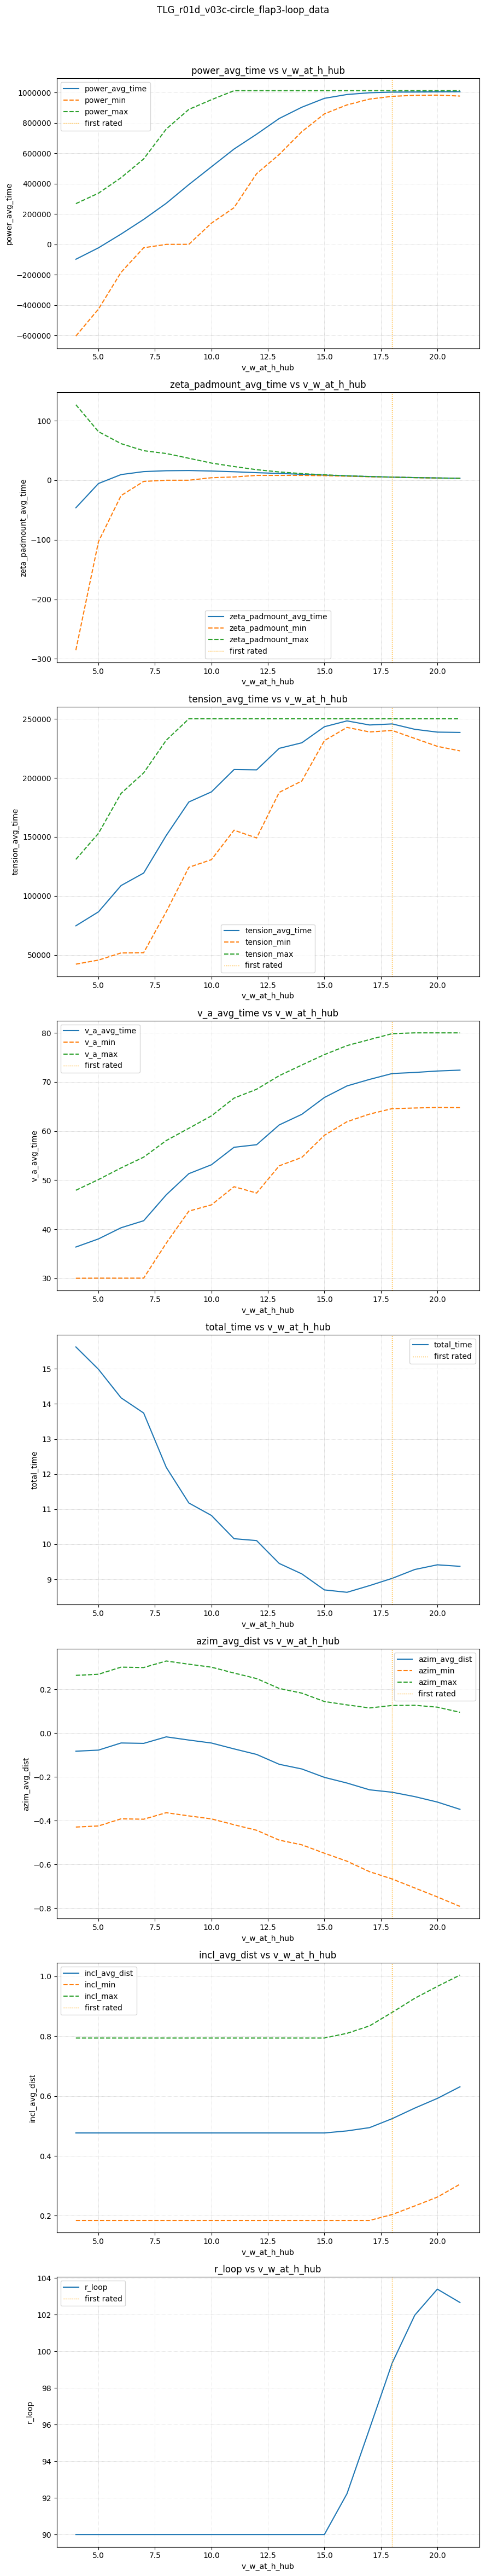

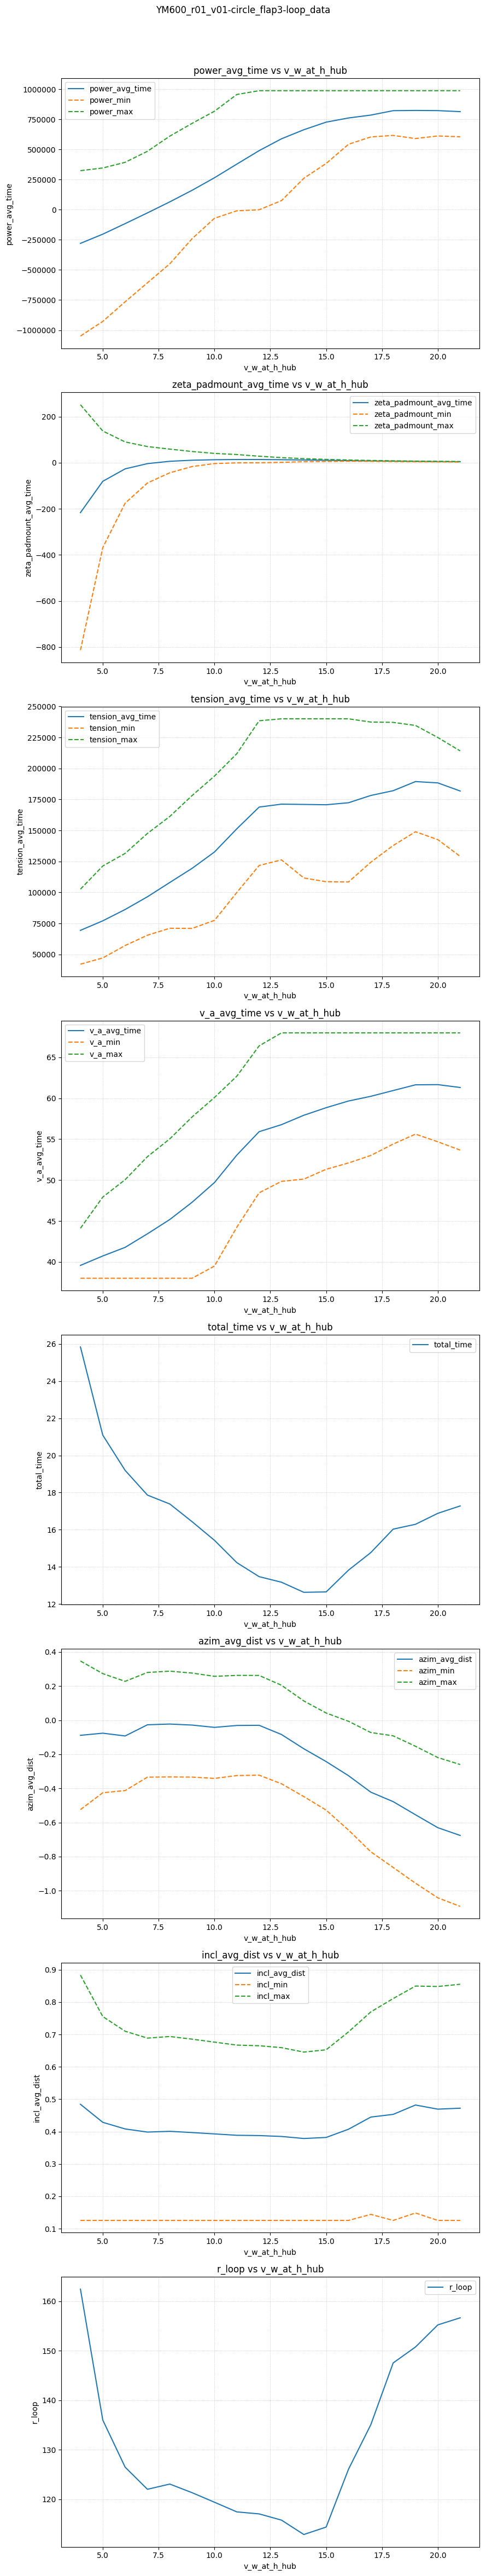

In [ ]:
#@title Plot ALL THE THINGS {form-width: "40%"}
#@markdown Or don't, by using the dropdown to select what plots to make/update.
#@markdown <br><br>Only plots items that don't need convergence data.

plots_to_make = 'loop_data' #@param ['all', 'power_curve', 'paths_locations', 'loop_data', 'pose_data', 'aero_device_scale', 'angular_rates', 'moments_b_xyz', 'flap_aero_coeffs', 'rotor_map', 'aero_moment_breakdown', 'constraints_final', 'aero_models']

for pc_name, pc in pcs.items():
  pc_figs[pc_name].update(
      PlotPowerCurveData(
          pc, plots=plots_to_make, figsize=(9,6), every_nth=2,
          pose_wrap_x=1.))
  kite_name = six.ensure_str(pc_name).split('-')[0]
  if plots_to_make=='all' or 'aero_models' in plots_to_make:
    pc_figs[pc_name].update(
        PlotAeroModels(kite_name, kites[kite_name], aero_models))
  for fig in pc_figs[pc_name]:
    pc_figs[pc_name][fig].suptitle('{}-{}'.format(pc_name, fig))
    pc_figs[pc_name][fig].tight_layout(rect=[0, 0, 1, 0.96])


In [ ]:
temp_f = pc_figs['TLG_r01d_v03c-circle_flap3']['loop_data']
ax_num = 2

ax = temp_f.axes[ax_num]
num_axes = len(temp_f.axes)
for ii, a in enumerate(temp_f.axes):
  if ii != ax_num:
    a.remove()
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_yticklabels(ax.get_yticks()/1000.)
ax.lines[-1].remove()

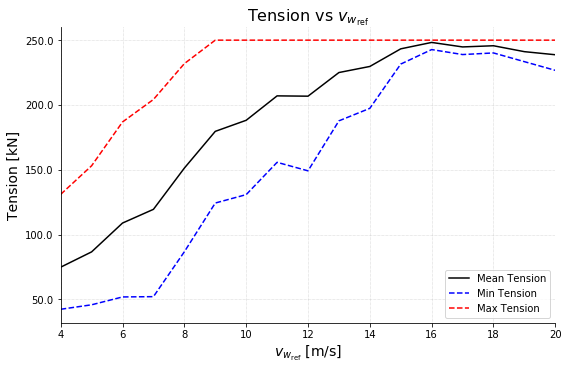

In [ ]:
titles = ['Power vs $v_{w_\mathrm{ref}}$','', 'Tension vs $v_{w_\mathrm{ref}}$']
ylabels = ['Electrical Power [kW]', '', 'Tension [kN]']
label_end = ['Power', '', 'Tension']

ax.set_title(titles[ax_num], size=16)
ax.set_xlabel('$v_{w_\mathrm{ref}}$ [m/s]', size=14)
ax.set_ylabel(ylabels[ax_num], size=14)
ax.set_xlim((4., 20.))
temp_f.suptitle('')
temp_f.set_dpi(72)
temp_f.set_figwidth(8)
temp_f.set_figheight(5*num_axes)
handles = []
colors = ['k', 'blue', 'red']

for ii, line in enumerate(ax.get_lines()):
  line.set_color(colors[ii])
  handles.append(line)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.legend(handles, ['Mean %s'%label_end[ax_num], 'Min %s'%label_end[ax_num], 'Max %s'%label_end[ax_num]])
temp_f

In [ ]:
temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
print(temp_pc.v_ws_at_h_ref)
print(np.round(np.array(temp_pc.powers)/1000.,1).tolist())

[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0]
[-97.9, -22.7, 67.9, 164.5, 270.7, 393.9, 511.1, 628.0, 725.9, 829.4, 903.6, 962.1, 987.5, 999.0, 1003.2, 1003.9, 1005.2, 1006.1]


(0, 314.1592653589793)

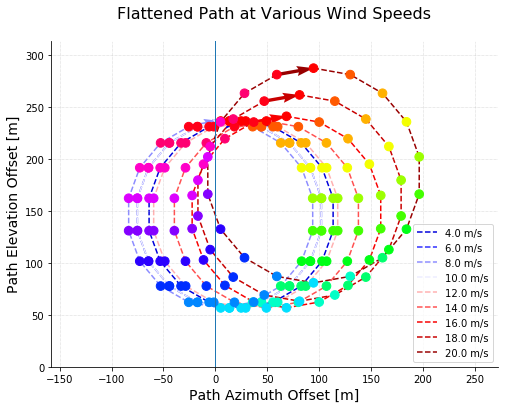

In [ ]:

temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
temp_f = temp_pc.plot_paths(
    with_azim_incl=True, figsize=(8,6), every_nth=2,
    pose_colormap='hsv', path_colormap='seismic')
ax = temp_f.axes[0]

ax.set_title('Flattened Path at Various Wind Speeds', size=16, y=1.05)
ax.set_xlabel('Path Azimuth Offset [m]', size=14)
ax.set_ylabel('Path Elevation Offset [m]', size=14)
temp_f.suptitle('')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_ylim((0, None))


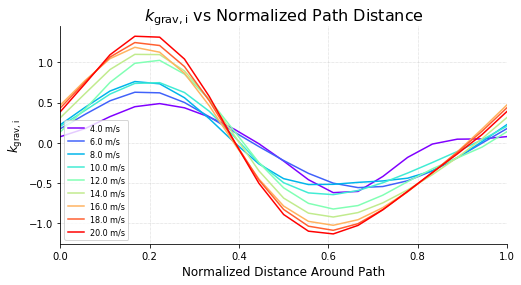

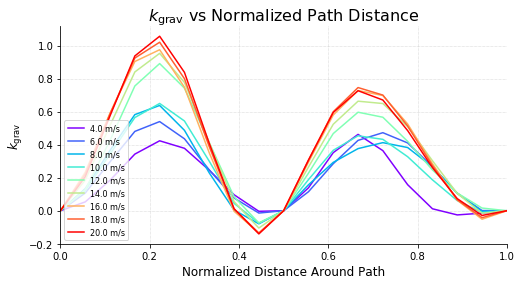

In [ ]:
#@title Plot PC DATA
temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
# for ii, loop in enumerate(temp_pc.loops):
#   print(loop.v_w_at_h_ref, np.average(np.abs(loop.data_poses['k_grav']),weights=1./loop.data_poses['v_k']))
# #*********************************************************************
# temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
# temp_f = temp_pc.plot_pose_data(
#     ys=['power'], every_nth=2, wrap_x=1.,
#     figsize=(8,5), dpi=None, legend_kwargs={'loc': 2, 'fontsize':14})
# ax = temp_f.gca()

# ax.set_title('Power vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel('Power [W]', size=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,1))
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:9], labels[:9], loc=1, prop={'size':8})
# ax.text(0.23, 32, 'Solid = $v_a$'+'\n'+'Dashed = $v_k$')
# #*********************************************************************
# temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
# temp_f = temp_pc.plot_pose_data(
#     ys=['v_a'], every_nth=2, wrap_x=1.,
#     figsize=(8,5), dpi=None, legend_kwargs={'loc': 2, 'fontsize':14})
# temp_f = temp_pc.plot_pose_data(
#     ys=['v_k'], every_nth=2, wrap_x=1.,
#     figsize=(7,4),
#     fig=temp_f, plot_kwargs={'linestyle':'--', 'linewidth': 1})
# ax = temp_f.gca()

# ax.set_title('Speed vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel('Speed [m/s]', size=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,1))
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:9], labels[:9], loc=1, prop={'size':8})
# ax.text(0.23, 32, 'Solid = $v_a$'+'\n'+'Dashed = $v_k$')

# #*********************************************************************
# temp_f = temp_pc.plot_pose_data(
#     ys=['alpha'], every_nth=2, wrap_x=1.,
#     figsize=(8,4))
# ax = temp_f.gca()

# ax.set_title('Alpha vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel(r'Alpha, $\alpha$ [deg]', size=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,1))
# ax.legend(loc=3, prop={'size':8})
# #*********************************************************************
temp_f = temp_pc.plot_pose_data(
    ys=['k_grav'], every_nth=2, wrap_x=1.,
    figsize=(8,4))
ax = temp_f.gca()

ax.set_title('$k_\mathrm{grav,i}$ vs Normalized Path Distance', size=16)
ax.set_xlabel('Normalized Distance Around Path', size=12)
ax.set_ylabel(r'$k_\mathrm{grav,i}$', size=12)
# ax.set_ylim((-2,2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((0,1))
ax.legend(loc=3, prop={'size':8})

temp_f = temp_pc.plot_pose_data(
    ys=['accel_Gs_along_G'], every_nth=2, wrap_x=1.,
    figsize=(8,4))
ax = temp_f.gca()

ax.set_title('$k_\mathrm{grav}$ vs Normalized Path Distance', size=16)
ax.set_xlabel('Normalized Distance Around Path', size=12)
ax.set_ylabel(r'$k_\mathrm{grav}$', size=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((0,1))
ax.legend(loc=3, prop={'size':8})

# #*********************************************************************
# temp_f = temp_pc.plot_pose_data(
#     ys=['eta_rotors'], every_nth=2, wrap_x=1.,
#     figsize=(8,4))
# ax = temp_f.gca()

# ax.set_title('$\eta_\mathrm{rotors}$ vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel(r'$\eta_\mathrm{rotors}$', size=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,1))
# ax.set_ylim((0.2,1))
# ax.legend(loc=3, prop={'size':8})
# #*********************************************************************
# temp_f = temp_pc.plot_pose_data(
#     ys=['tether_roll_angle'], every_nth=2, wrap_x=1.,
#     figsize=(8,4))
# ax = temp_f.gca()

# ax.set_title('Tether Roll Angle vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel(r'Tether Roll Angle', size=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,1))
# ax.legend(loc=3, prop={'size':8})

#*********************************************************************
# from matplotlib import lines
# temp_f = temp_pc.plot_vectors(
#     ys=['pqr'], ys_components=[['p', 'q', 'r']], every_nth=2, wrap_x=1.,
#     figsize=(8,5))
# ax = temp_f.gca()
# temp_f.set_figwidth(8)
# temp_f.set_figheight(5)
# temp_f.set_dpi(80)

# ax.set_title('Body Rates vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel(r'Body Rates [rad/s]', size=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,None))
# custom_lines = []
# for ii, wind in enumerate(temp_pc.v_ws_at_h_ref[::2]):
#   custom_lines.append(lines.Line2D([0], [0], color=plt.cm.rainbow(float(ii)/(len(temp_pc.v_ws_at_h_ref[::2])-1.)), lw=3))
# custom_lines.append(lines.Line2D([0], [0], color='k', lw=1, linestyle='-'))
# custom_lines.append(lines.Line2D([0], [0], color='k', lw=1, linestyle='--'))
# custom_lines.append(lines.Line2D([0], [0], color='k', lw=1, linestyle='-.'))
# custom_labels=['$v_{w_{ref}}$ = %d m/s'%w for w in temp_pc.v_ws_at_h_ref[::2]]
# custom_labels.extend(['p, roll rate', 'q, pitch rate', 'r, yaw rate'])
# ax.legend(custom_lines, custom_labels, loc=2, fontsize=12, bbox_to_anchor=(1.0, 1))

# #*********************************************************************
# temp_f = temp_pc.plot_vectors_components(
#         ys=[['moments_b', 'type', t] for t in
#             ['rotors', 'aero', 'tether', 'inertial', 'gravity', 'residual']],
#         y_components=['x', 'y', 'z'],
#         ys_labels=['m_rotors', 'm_aero', 'm_tether', 'm_inertial', 'm_gravity',
#                   'm_residual'],
#         every_nth=2, figsize=(8,5))
# ax = temp_f.gca()
# temp_f.set_figwidth(8)
# temp_f.set_figheight(15)
# temp_f.set_dpi(80)

# ax.set_title('Body Rates vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel(r'Body Rates [rad/s]', size=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,None))
# custom_lines = []
# for ii, wind in enumerate(temp_pc.v_ws_at_h_ref[::2]):
#   custom_lines.append(lines.Line2D([0], [0], color=plt.cm.rainbow(float(ii)/(len(temp_pc.v_ws_at_h_ref[::2])-1.)), lw=3))
# custom_lines.append(lines.Line2D([0], [0], color='k', lw=1, linestyle='-'))
# custom_lines.append(lines.Line2D([0], [0], color='k', lw=1, linestyle='--'))
# custom_lines.append(lines.Line2D([0], [0], color='k', lw=1, linestyle='-.'))
# custom_labels=['$v_{w_{ref}}$ = %d m/s'%w for w in temp_pc.v_ws_at_h_ref[::2]]
# custom_labels.extend(['p, roll rate', 'q, pitch rate', 'r, yaw rate'])
# ax.legend(custom_lines, custom_labels, loc=2, fontsize=12, bbox_to_anchor=(1.0, 1))

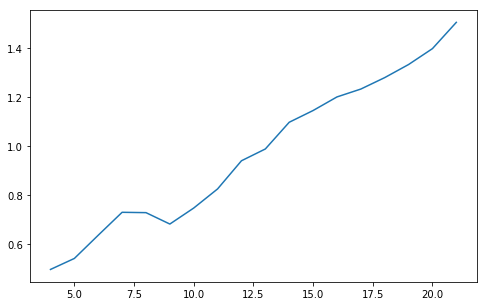

In [ ]:
plt.figure(figsize=(8,5))
for ii, loop in enumerate(temp_pc.loops):
  ks = np.diff(loop.data_poses['kinetic_E'])/-np.diff(loop.data_poses['potential_E'])
  # print(np.diff(loop.data_poses['potential_E']))
  # plt.plot(loop.data_poses['dist_norm'][1:], ks, color=cm.coolwarm(float(ii)/(len(temp_pc.v_ws_at_h_hub)-1.)))
  # plt.plot(loop.data_poses['total_E'])

# plt.ylim((-4,4))
plt.plot(temp_pc.v_ws_at_h_ref,
         [(max(loop.data_poses['kinetic_E'])-min(loop.data_poses['kinetic_E']))/(max(loop.data_poses['potential_E'])-min(loop.data_poses['potential_E'])) for loop in temp_pc.loops])

(70, 83)

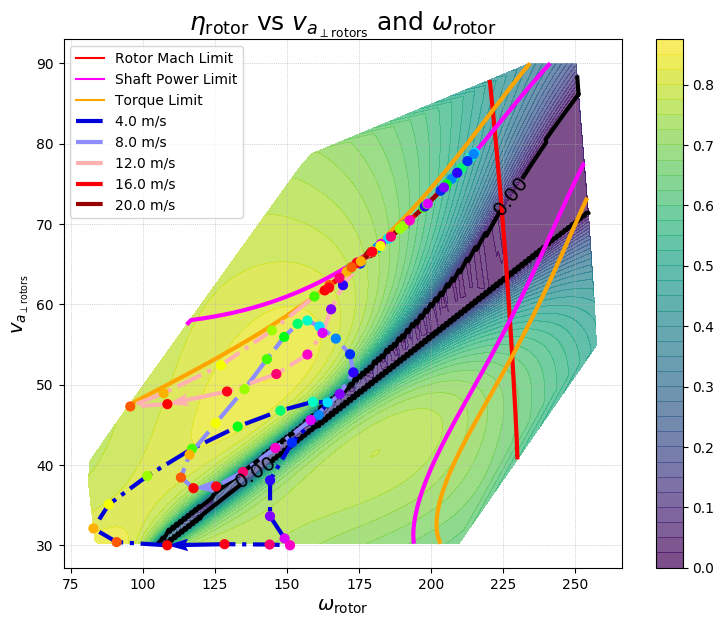

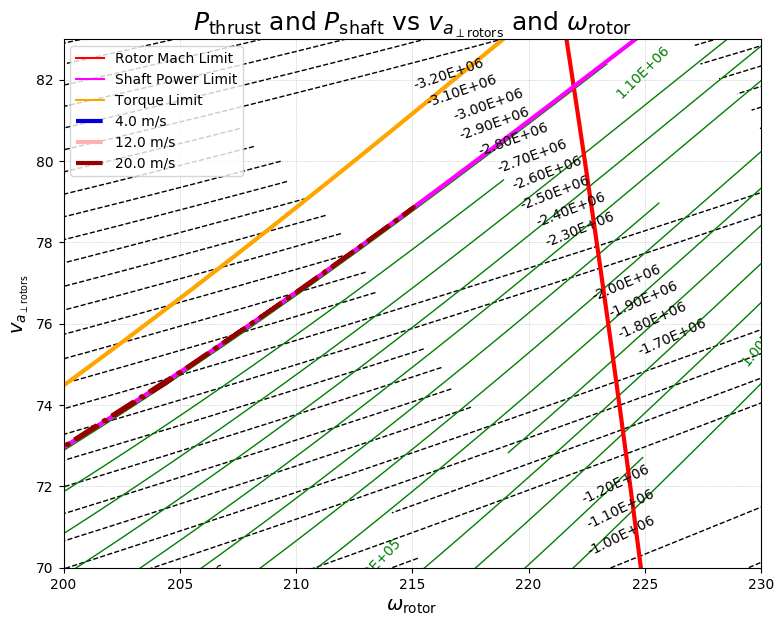

In [ ]:
temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
#*********************************************************************
temp_f = temp_pc.plot_rotor_map(
    zs=['eta_rotors'], every_nth=4,
    colormap='viridis', levels=12, show_contour_lines=False,
    pose_colormap='hsv', path_colormap='seismic', path_width=3,
    pose_markersize=40, map_alpha=0.7)
ax = temp_f.gca()

ax.set_title(
    r'$\eta_\mathrm{rotor}$ vs $v_{a_{\perp\mathrm{rotors}}}$ and $\omega_\mathrm{rotor}$', size=18)
ax.set_ylabel('$v_{a_{\perp\mathrm{rotors}}}$', size=14)
ax.set_xlabel('$\omega_\mathrm{rotor}$', size=14)
temp_f.suptitle('')

handles, labels = ax.get_legend_handles_labels()
handles.pop(0)
labels.pop(0)
labels[0] = 'Rotor Mach Limit'
labels[1] = 'Shaft Power Limit'
labels[2] = 'Torque Limit'
ax.legend(handles, labels)

ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,1))
# ax.set_ylim((0.2,1))
# ax.legend(loc=3, prop={'size':8})

#*********************************************************************
temp_f = temp_pc.plot_rotor_map(
    zs=['aero_thrust_power'], every_nth=8,
    colormap='viridis', levels=np.linspace(-4000000., 0., 41),
    show_contour_lines=True,
    pose_colormap='hsv', path_colormap='seismic', path_width=3,
    pose_markersize=0, map_alpha=0.7, show_map=False,
    extra_contours=('power_shaft', np.linspace(0., 1200000., 13), 'green'),
    skip_contours=['rotor_stall_margin', 'torque_shaft_max_margin'],
    contour_label_fmt='%0.2E')
ax = temp_f.gca()

ax.set_title(
    r'$P_\mathrm{thrust}$ and $P_\mathrm{shaft}$ vs $v_{a_{\perp\mathrm{rotors}}}$ and $\omega_\mathrm{rotor}$', size=18)
ax.set_ylabel('$v_{a_{\perp\mathrm{rotors}}}$', size=14)
ax.set_xlabel('$\omega_\mathrm{rotor}$', size=14)
temp_f.suptitle('')

handles, labels = ax.get_legend_handles_labels()
handles.pop(0)
labels.pop(0)
labels[0] = 'Rotor Mach Limit'
labels[1] = 'Shaft Power Limit'
labels[2] = 'Torque Limit'
ax.legend(handles, labels, loc=2)

ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((200,230))
ax.set_ylim((70,83))
# ax.legend(loc=3, prop={'size':8})

In [ ]:
from scipy.optimize import minimize_scalar

def balance_forces(inputs):
  """Changes input dict lift_roll_angle to balance forces in pose defined by
  inputs"""
  def eval_pose_net(lift_roll_angle):
    inputs['lift_roll_angle'] = lift_roll_angle
    pose = kite_pose.KitePose(**inputs)
    pose.solve()

    for c in pose.state['constraints']:
      if c['name'] == 'net_margin':
        out = c['value']
    return out
  result = minimize_scalar(
      eval_pose_net, bounds=(-math.pi, math.pi), tol=0.00001,
      bracket=(inputs['lift_roll_angle']-1e-5, inputs['lift_roll_angle']+1e-5),
      options={'maxiter': 18},
      method='bounded')

def local_deriv(pose, var, numerator='power', **kwargs):
  step = kwargs.get('step', 1e-4)
  bal_forces = kwargs.get('bal_forces', False)
  offset = kwargs.get('offset', None)
  wind_offset = kwargs.get('wind_offset', None)

  state_input_keys = ['v_k', 'accel_along_path', 'pqr', 'pqr_dot', 'alpha', 'beta',
                      'lift_roll_angle', 'v_w_hat', 'aero_device_scale', 'grav_mult']
  other_init_keys = ['position', 'resource', 'config', 'v_w_at_h_ref']
  position_input_keys = ['r_curv', 'r_curve_hat']
  
  inits = dict([(k, pose[k]) for k in other_init_keys])
  inputs_i = dict([(k, pose.state[k]) for k in state_input_keys if k in pose.state])
  inputs_i.update(inits)
  
  if offset is not None:
    inputs_i[var] += offset
  if wind_offset is not None:
    inputs_i['v_w_at_h_ref'] += wind_offset
  
  inputs_l = utils.deepcopy_lite(inputs_i)
  inputs_l[var] -= step
  inputs_h = utils.deepcopy_lite(inputs_i)
  inputs_h[var] += step
  
  d_var = inputs_h[var] - inputs_l[var]

  # print('{:0.2f}'.format(inputs_i['lift_roll_angle']), end='')
  if bal_forces:
    balance_forces(inputs_l)
    balance_forces(inputs_h)
  # print(', {:0.2f}'.format(inputs_l['lift_roll_angle']), end='')
  # print(', {:0.2f}'.format(inputs_h['lift_roll_angle']))
  
  pose_low = kite_pose.KitePose(**inputs_l)
  pose_low.solve()
  pose_high = kite_pose.KitePose(**inputs_h)
  pose_high.solve()
  
  d_num = pose_high.state[numerator] - pose_low.state[numerator]
  return d_num / d_var

def local_deriv_sweep_pc(pc, sweep_var='v_k', numerator='power',
                      extra_output_vars=['power'], every_nth=1, **kwargs):
  output = {'deriv': [],
            'var': sweep_var,
            'numerator': numerator,
            'winds': pc.v_ws_at_h_ref}
  for k in extra_output_vars:
    output[k] = []

  for loop in pc.loops:
    #-yz plane is looking downwind
    pose_idx = [idx for idx in range(len(loop.poses)) if idx % every_nth == 0]
    output['deriv'].append(
        [local_deriv(loop.poses[idx], sweep_var, numerator=numerator, **kwargs)
         for idx in pose_idx])
    for k in extra_output_vars:
      output[k].append([loop.data_poses[k][idx] for idx in pose_idx])

  return output

# def local_deriv_sweep_loop(pc, sweep_var='v_a', numerator='power',
#                       extra_output_vars=['power'], every_nth=1, **kwargs):

def plot_deriv_sweep(data, x='dist_norm', y='deriv', **kwargs):
  units = kwargs.get('units', ('', ''))
  every_nth = kwargs.get('every_nth', 1)
  wrap_x = kwargs.get('wrap_x', None)
  
  xs = data[x].tolist() if hasattr(data[x], 'tolist') else data[x]
  ys = data[y].tolist() if hasattr(data[y], 'tolist') else data[y]

  if wrap_x is not None:
    for ii, (row_x, row_y) in enumerate(zip(xs, ys)):
      xs[ii] = row_x + [wrap_x]
      ys[ii] = row_y + [row_y[0]]

  fig = plt.figure(figsize=(8,6))
  ax = fig.gca()
  ax.set_title('d_%s / d_%s vs %s @ various winds' % (data['numerator'], data['var'], x))
  ax.set_xlabel('%s [%s]' % (x, units[0]))
  ax.set_ylabel('%s / %s [%s]' % (data['numerator'], data['var'], units[1]))
  for ii, (x, y, w) in enumerate(zip(xs, ys, data['winds'])):
    if ii % every_nth == 0:
      wind_norm = float(data['winds'].index(w))/(len(data['winds'])-1)
      ax.plot(x, y, label=('%0.1fm/s'%w), color=cm.rainbow(wind_norm))
      ax.grid(linestyle=':', linewidth=0.5)
      ax.legend()
  return fig


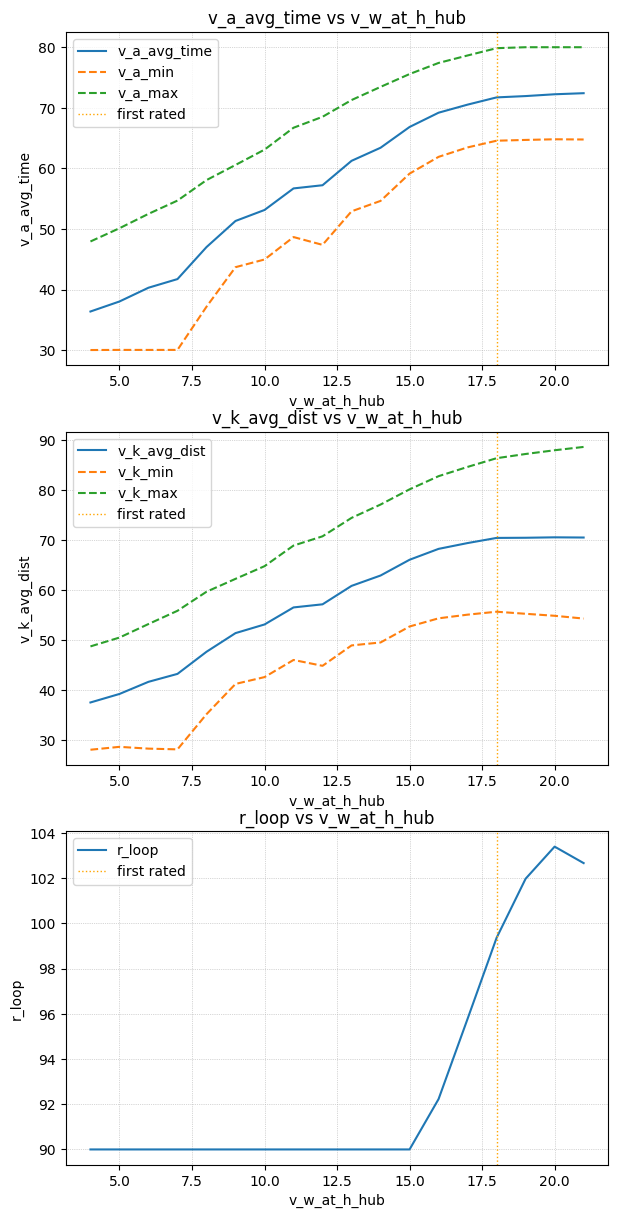

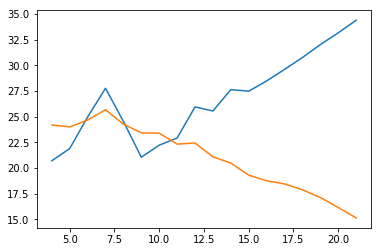

In [ ]:
def DeltaVk(r_loop, g, k_grav, theta_e, v_kL):
  return 2. * r_loop * g * k_grav * np.cos(theta_e) / v_kL

temp_pc = pcs['TLG_r01d_v03c-circle_flap3']

# print(isinstance(temp_pc.loops[0].poses[0].state['v_k'], numbers.Number))

d_vk_fbl = [max(loop.data_poses['v_k']) - min(loop.data_poses['v_k']) for loop in temp_pc.loops]
vk_bar_fbl = [0.5*(max(loop.data_poses['v_k']) + min(loop.data_poses['v_k'])) for loop in temp_pc.loops]
# vk_bar_fbl = [loop.data_loop['v_k_avg_dist'] for loop in temp_pc.loops]
v_ws = [loop.v_w_at_h_ref for loop in temp_pc.loops]
r_loops = np.array([loop.path.r_loop for loop in temp_pc.loops])
d_vk_a = DeltaVk(r_loops, 9.81, 0.75, temp_pc.loops[0].path['incl'], np.array(vk_bar_fbl))

temp_pc.plot_loop_data(ys=['v_a_avg_time', 'v_k_avg_dist', 'r_loop'])

plt.figure()
plt.plot(v_ws, d_vk_fbl)
plt.plot(v_ws, d_vk_a)

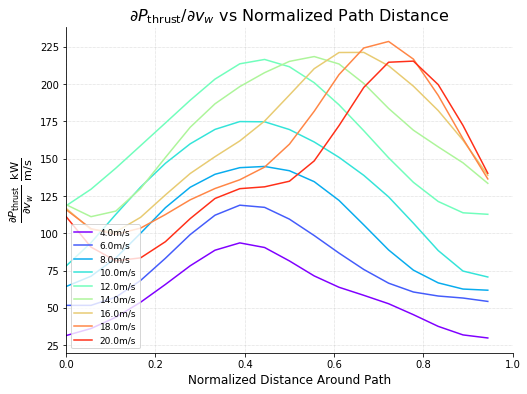

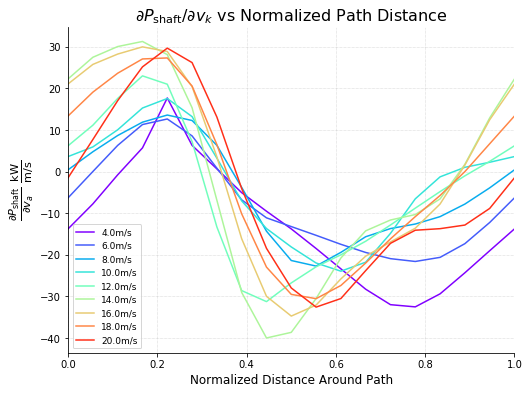

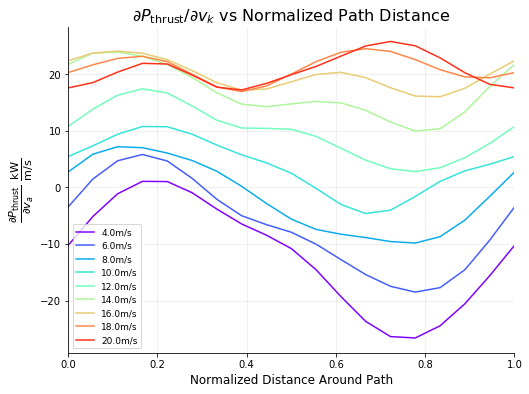

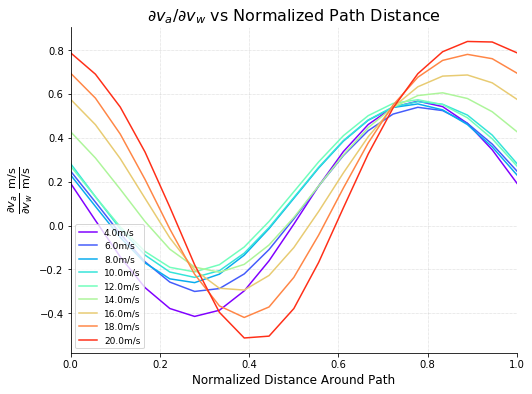

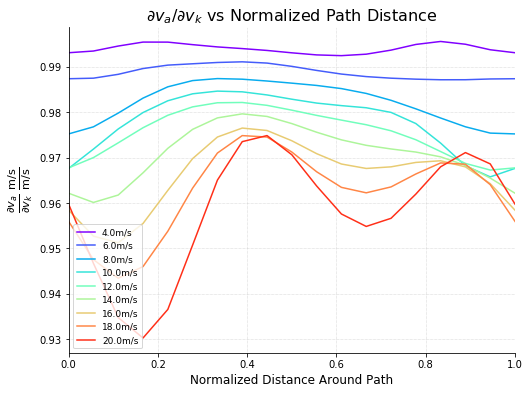

In [ ]:
#@title Partial Derivative Plots

# temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
temp_pc = pcs['YM600_r01_v01-circle_flap3']

#*******************************************************          
deriv_sweep = local_deriv_sweep_pc(
    temp_pc, sweep_var='v_w_at_h_ref', extra_output_vars=['dist_norm', 'c_t'],
    numerator='rotor_thrust_power', every_nth=1, step=1e-1, bal_forces=True)
deriv_sweep['deriv'] = -np.array(deriv_sweep['deriv'])/1000.
fig = plot_deriv_sweep(
    deriv_sweep,
    units=('-', 'kW/(m/s)'), wrap_x=None, every_nth=2)
fig.set_figwidth(8)
fig.set_figheight(6)
ax = fig.gca()
ax.set_xlim((0,1))

ax.set_title('$\partial P_\mathrm{thrust} / \partial v_w$ vs Normalized Path Distance', size=16)
ax.set_xlabel('Normalized Distance Around Path', size=12)
ax.set_ylabel(r'$\frac{\partial P_\mathrm{thrust}}{\partial v_w}\; \frac{\mathrm{kW}}{\mathrm{m/s}}$' , size=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((0,1))
ax.legend(loc=3, prop={'size':9})

# *******************************************************                
# deriv_sweep = local_deriv_sweep_pc(
#     temp_pc, sweep_var='alpha', extra_output_vars=['dist_norm'],
#     numerator='rotor_thrust_power', every_nth=1, step=1e-4)
# deriv_sweep['deriv'] = -np.array(deriv_sweep['deriv'])/1000.
# fig = plot_deriv_sweep(
#     deriv_sweep,
#     units=('-', 'kW/(m/s)'), wrap_x=1., every_nth=2)
# ax = fig.gca()
# ax.set_xlim((0,1))

# ax.set_title(r'$\partial P_\mathrm{thrust} / \partial \alpha$ vs Normalized Path Distance', size=16)
# ax.set_xlabel('Normalized Distance Around Path', size=12)
# ax.set_ylabel(r'$\frac{\partial P_\mathrm{thrust}}{\partial \alpha}\; \frac{\mathrm{kW}}{\mathrm{deg}}$', size=16)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(linewidth=0.5, linestyle=':')
# ax.set_xlim((0,1))
# ax.legend(loc=2, prop={'size':9})

#*******************************************************                
deriv_sweep = local_deriv_sweep_pc(
    temp_pc, sweep_var='v_k', extra_output_vars=['dist_norm', 'lift_roll_angle'],
    numerator='power_shaft', every_nth=1, step=1e-2, bal_forces=False, offset=0.,
    wind_offset=0.)
deriv_sweep['deriv'] = np.array(deriv_sweep['deriv'])/1000.
fig = plot_deriv_sweep(
    deriv_sweep, units=('-', 'kW/(m/s)'),
    wrap_x=1., every_nth=2)
fig.set_figwidth(8)
fig.set_figheight(6)
ax = fig.gca()
ax.set_xlim((0,1))

ax.set_title(r'$\partial P_\mathrm{shaft} / \partial v_k$ vs Normalized Path Distance', size=16)
ax.set_xlabel('Normalized Distance Around Path', size=12)
ax.set_ylabel(r'$\frac{\partial P_\mathrm{shaft}}{\partial v_a}\; \frac{\mathrm{kW}}{\mathrm{m/s}}$', size=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((0,1))
ax.legend(loc=3, prop={'size':9})

#*******************************************************                
deriv_sweep = local_deriv_sweep_pc(
    temp_pc, sweep_var='v_k', extra_output_vars=['dist_norm', 'lift_roll_angle', 'v_a_along_rotor_axis'],
    numerator='rotor_thrust_power', every_nth=1, step=1e-2, bal_forces=False, offset=0.,
    wind_offset=0.)
deriv_sweep['deriv'] = -np.array(deriv_sweep['deriv'])/1000.
fig = plot_deriv_sweep(
    deriv_sweep, units=('-', 'kW/(m/s)'),
    wrap_x=1., every_nth=2)
fig.set_figwidth(8)
fig.set_figheight(6)
ax = fig.gca()
ax.set_xlim((0,1))

ax.set_title(r'$\partial P_\mathrm{thrust} / \partial v_k$ vs Normalized Path Distance', size=16)
ax.set_xlabel('Normalized Distance Around Path', size=12)
ax.set_ylabel(r'$\frac{\partial P_\mathrm{thrust}}{\partial v_a}\; \frac{\mathrm{kW}}{\mathrm{m/s}}$', size=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((0,1))
ax.legend(loc=3, prop={'size':9})
# #*******************************************************                
deriv_sweep = local_deriv_sweep_pc(
    temp_pc, sweep_var='v_w_at_h_ref', extra_output_vars=['dist_norm', 'lift_roll_angle'],
    numerator='v_a_along_rotor_axis', every_nth=1, step=1e-1, bal_forces=True, offset=0.,
    wind_offset=0.)
deriv_sweep['deriv'] = np.array(deriv_sweep['deriv'])
fig = plot_deriv_sweep(
    deriv_sweep, units=('-', 'kW/(m/s)'),
    wrap_x=1., every_nth=2)
fig.set_figwidth(8)
fig.set_figheight(6)
ax = fig.gca()
ax.set_xlim((0,1))

ax.set_title(r'$\partial v_a / \partial v_w$ vs Normalized Path Distance', size=16)
ax.set_xlabel('Normalized Distance Around Path', size=12)
ax.set_ylabel(r'$\frac{\partial v_a}{\partial v_w}\; \frac{\mathrm{m/s}}{\mathrm{m/s}}$', size=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((0,1))
ax.legend(loc=3, prop={'size':9})

# #*******************************************************                
deriv_sweep = local_deriv_sweep_pc(
    temp_pc, sweep_var='v_k', extra_output_vars=['dist_norm'],
    numerator='v_a_along_rotor_axis', every_nth=1, step=1e-2, bal_forces=False, offset=0.,
    wind_offset=0.)
deriv_sweep['deriv'] = np.array(deriv_sweep['deriv'])
fig = plot_deriv_sweep(
    deriv_sweep, units=('-', 'kW/(m/s)'),
    wrap_x=1., every_nth=2)
fig.set_figwidth(8)
fig.set_figheight(6)
ax = fig.gca()
ax.set_xlim((0,1))

ax.set_title(r'$\partial v_a / \partial v_k$ vs Normalized Path Distance', size=16)
ax.set_xlabel('Normalized Distance Around Path', size=12)
ax.set_ylabel(r'$\frac{\partial v_a}{\partial v_k}\; \frac{\mathrm{m/s}}{\mathrm{m/s}}$', size=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linewidth=0.5, linestyle=':')
ax.set_xlim((0,1))
ax.legend(loc=3, prop={'size':9})



In [ ]:
temp_pc = pcs['TLG_r01d_v03c-circle_flap3']

print(temp_pc.v_ws_at_h_ref)
print(np.round(np.array(temp_pc.powers)/1000.).tolist())

[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0]
[-98.0, -23.0, 68.0, 164.0, 271.0, 394.0, 511.0, 628.0, 726.0, 829.0, 904.0, 962.0, 987.0, 999.0, 1003.0, 1004.0, 1005.0, 1006.0]


Wind:  20.0


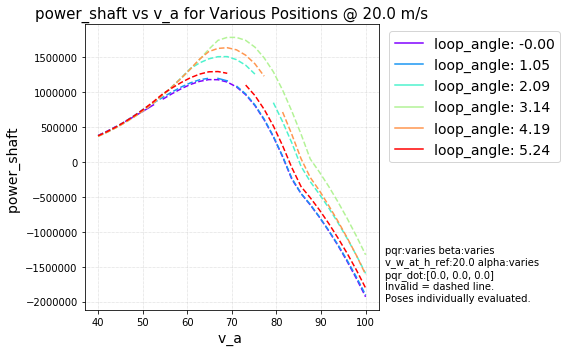

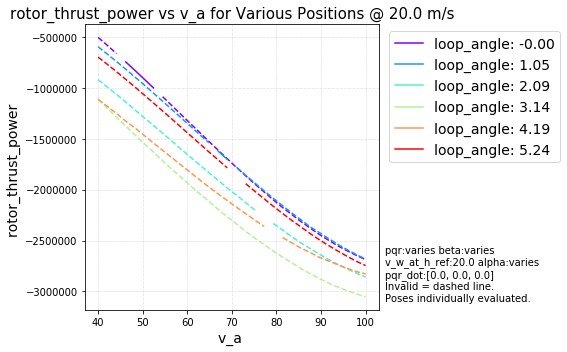

In [ ]:
temp_pc = pcs['TLG_r01d_v03c-circle_flap3']
# temp_pc = pcs['YM600_r01_v01-circle_flap3']
wind_idxs = [-2]

positions = [temp_pc.loops[w].path.positions for w in wind_idxs]
winds = [temp_pc.loops[w].v_w_at_h_ref for w in wind_idxs]
pqrs = [[p.state['pqr'] for p in temp_pc.loops[w].poses] for w in wind_idxs]
accels = [[p.state['accel_along_path'] for p in temp_pc.loops[w].poses] for w in wind_idxs]
alphas = [[p.state['alpha'] for p in temp_pc.loops[w].poses] for w in wind_idxs]
betas = [[p.state['beta'] for p in temp_pc.loops[w].poses] for w in wind_idxs]

for pos, ac, a, b, p, w in zip(positions, accels, alphas, betas, pqrs, winds):
    print('Wind: ', w)
    kite_loop.plot_var_sweep(
        pos, temp_pc.resource, temp_pc.config,
        var_to_sweep='v_a', var_range=(40., 100., 30),
        v_w_at_h_ref=w, k_grav=None,
        every_nth=3, accel_along_path=ac, pqr=p, alpha=a, beta=b,
        vars_to_plot=['power_shaft', 'rotor_thrust_power'],
        legend_key='loop_angle',
        figsize=(8,5))

In [ ]:
#@title Export data and figures
_dry_run = False #@param {type:"boolean"}
_export_type = "data" #@param ['all', 'figs', 'data']
ExportFigsData(
    pcs,
    pc_figs,
    export_path=pcs_subdir,
    pc_desc=pc_desc,
    export_type=_export_type,
    dryrun=_dry_run,
)


Exporting results to: /Volumes/GoogleDrive/Shared drives/Makani_FBL/PowerCurves/FOR_RELEASE
Power curve results to overwrite:
['TLG_r01d_v03c-circle_flap3.json']
Exporting TLG_r01d_v03c-circle_flap3
TLG_r01d_v03c-circle_flap3.json exported successfully
Exporting YM600_r01_v01-circle_flap3
YM600_r01_v01-circle_flap3.json exported successfully
Export complete


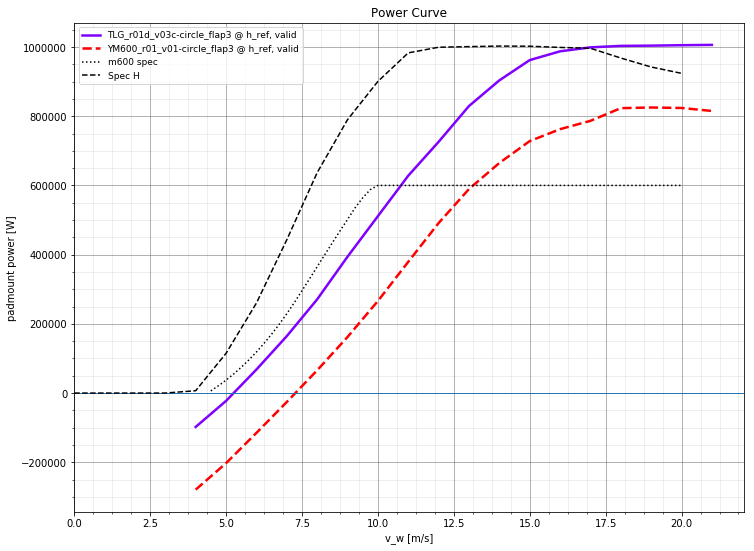

In [ ]:
#@title Compare (and export) all power curves
_export_pc_fig = False #@param {type:"boolean"}
_pc_plot_export_suffix = '_BSFs' #@param {type:'string'}
_pc_fig_kwarg = (
    {} if not _export_pc_fig else {
        'export_name': 'PowerCurve_Comparison' + six.ensure_str(_pc_plot_export_suffix),
        'export_path': pcs_subdir})
power_curve_comparison = compare_power_curves(
    pcs, **_pc_fig_kwarg
)


## Explore Plots

In [ ]:
#@title Available power curves
pp(sorted(pcs.keys()))


In [ ]:
#@title Compare (and export) subset of power curves

pcs_to_compare= [ # load select power curves
    'BigM600_r02a_v06b-circle',
    'BigM600_r02c_v07a-circle',
    'BigM600_r02c_v07b-circle',
    # 'Biplane_r03a_v03-circle',
    # 'Biplane_r03c_v04a-circle',
    # 'Biplane_r03c_v04b-circle',
    'Ellip_r02a_v04b-circle',
    'Ellip_r02b_v05a-circle',
    'Ellip_r02b_v05b-circle',
    # 'Prandtl_r01b_v04c-circle',
    # 'Prandtl_r01c_v05a-circle',
    # 'Prandtl_r01c_v05b-circle',
    # 'Prandtl_r01c_v06a-circle',
    # 'Prandtl_r01c_v06b-circle',
    # 'YM600_r01_v01-circle',
    # 'YM600_r01_v02-circle'
 ]

_export_pc_fig = False #@param {type:"boolean"}
_pc_plot_export_suffix = '_subset' #@param {type:'string'}
_pc_fig_kwarg = (
    {} if not _export_pc_fig else {
        'export_name': 'PowerCurve_Comparison' + six.ensure_str(_pc_plot_export_suffix),
        'export_path': pcs_subdir})
power_curve_comparison = compare_power_curves(
    {pc:pcs[pc] for pc in pcs_to_compare}, **_pc_fig_kwarg
)


In [ ]:
#@title Set pc_name to explore
# pc_name = 'BigM600_r02a_v06b-circle'
pc_name = list(pcs.keys())[0]

print(pc_name)


In [ ]:
#@title display all figures for pc_name { form-width: "20%" }

figs_to_plot = ([plot for plot in plot_order if plot in pc_figs[pc_name]] +
                [fig for fig in pc_figs[pc_name] if fig not in plot_order])
for fig in figs_to_plot:
  display(pc_figs[pc_name][fig])


# Load in params and regenerate power_curve objects

In [ ]:
#@title View available studies and power curves

print('Available studies:')
print((sorted(os.listdir(pc_dir))))
print()
print('Available power_curves in {}:'.format(os.path.basename(pcs_subdir)))
all_pc_names = sorted([name for name in os.listdir(pcs_subdir) if (six.ensure_str(name).endswith('.json') and 'sensitivity' not in name)])
pp(all_pc_names)


Available studies:
['20190703_initial_paths', '20190712_initial_stackup', '20190717_clean_stackup', '20190721_Fig8s', '20190722_Fig8s_splines', '20190729_pencil_specs', '20190805_opt_sensitivities', '20190806_rotors', '20190814_ConceptEval', '20190821_PracticeTrials', '20190822_LoopRadiusStudy', '20190822_NewRotorModel', '20190827_ConceptEval', '20190829_BigM600_Sensitivity', '20190829_test_c_lmn_limits', '20190830_Rotor3dFits', '20190830_RotorSensitivity', '20190830_SensitivityTrials', '20190903_ConceptEval', '20190904_test_c_lmn_limits', '20190906_YM600_r01_v01_Sensitivity', '20190907_ConceptEval', '20190907_ConceptEval_Biplane_r03d_mistake_dump', '20190908_SensitivityTrials', '20190926_Sensitivity', '20191004_Sensitivity', '20191011_2MW', '20191011_TailSweeps', '20191014_M600Sensitivity', '20191105_Daggerons', '20191118_TLGConceptEval', '20200130_BSF,TLG', '20200204_CG_Sensitivity', 'FOR_RELEASE', 'OktKite_BSF', 'OktKite_BSF,BigM600_r07c_v01']

Available power_curves in FOR_RELEASE:

In [ ]:
#@title Select files to load

pc_file_names_to_load = [
    'YM600_r01_v01-circle_flap3.json',
    'TLG_r01d_v03c-circle_flap3.json',
]

print('Power curves to load: ')
pp(sorted(pc_file_names_to_load))



Power curves to load: 
['TLG_r01d_v03c-circle_flap3.json', 'YM600_r01_v01-circle_flap3.json']


In [ ]:
#@title Load params and generate power_curves { form-width: "20%" }
#@markdown If a kite of matching name is not available in kites, this will now recreates the kite config using the override string. 

#@markdown Once loaded, can remake the plots and export/explore as needed by going back up to the 'Plot Results and Export' section

#@markdown Check to start fresh power curve dictionary.
reset_pcs_and_figs = True #@param {type: 'boolean'}
if reset_pcs_and_figs:
  pcs = {}
  pc_figs = {}
else:
  try:
    print(pcs)
  except:
    pcs = {}
    pc_figs = {}

for pc_file in pc_file_names_to_load:
  pc = six.ensure_str(pc_file).split('.')[0]
  kite_name = six.ensure_str(pc).split('-')[0]
  with open(os.path.join(pcs_subdir, pc_file), 'r') as f:
    pc_in = json.load(f)
  if kite_name not in kites:
    print('Adding {} to kites.'.format(kite_name))
    configs.UpdateKitesAndModelsFromOverride(
        pc_in['sheets_override'], kites, aero_models, bridle_models)
  pcs[pc] = makani_FBL.KitePowerCurve(
      resource,
      kites[kite_name],
      v_w_at_h_ref_range=pc_in['wind_params']['v_w_at_h_ref_range'],
      v_w_step=pc_in['wind_params']['v_w_step'],
      **pc_in['loop_params'])
  pc_figs[pc] = {}

  print('Loaded {}'.format(pc))
  pcs[pc].solve()
  if pcs[pc]['solve_summary'] == pc_in['solve_summary']:
    print('Success: solve_summaries match.')
  else:
    print('WARNING: The solve_summaries for {} do not seem to match:'.format(kite_name))
    print('What was exported in the json:')
    print(pc_in['solve_summary'])
    print('From the freshly calculated power curve:')
    print(pcs[pc]['solve_summary'])
  print('')


Loaded YM600_r01_v01-circle_flap3
Solving for v_ws at h_ref: 
'V' for Valid, 'I' for Invalid
   4.0m/s       5.0m/s       6.0m/s       7.0m/s       8.0m/s       9.0m/s       10.0m/s      11.0m/s      12.0m/s      13.0m/s      14.0m/s      15.0m/s      16.0m/s      17.0m/s      18.0m/s      19.0m/s      20.0m/s      21.0m/s   
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 V: -279 kW   V: -202 kW   V: -115 kW    V: -25 kW    V: 65 kW     V: 161 kW    V: 265 kW    V: 379 kW    V: 491 kW    V: 589 kW    V: 664 kW    V: 728 kW    V: 762 kW    V: 786 kW    V: 823 kW    V: 825 kW    V: 823 kW    V: 815 kW  


Time to solve power curve is 1.35s
What was exported in the json:
Solved for v_ws at h_ref: 
'V' for Valid, 'I' for Invalid
    4m/s         5m/s         6m/s         7m/s         8m/s         9m/s  

# Deprecated/Draft

In [ ]:
#@title look at cap factors

from lib import params
from mx_sys import const
from mx_sys import model
from mx_sys import AWE_sys
from mx_sys.plant_sys import plant
from lib import fun
from mx_sys import econ
from mx_sys import resource as mx_resource

# I use the resource yaml to populate an MX_modeling resource object
resource_params = model.Spec('../inputs/nom_resource.yaml')
nom_resource = mx_resource.Resource()
nom_resource.Populate(resource_params)
# then I step on values I want to overwrite
# alternatively, you could just make a new resource file and point it to that
nom_resource.shear = 0.11
nom_resource.rho = 1.225
nom_resource.v_w_avg_h_ref = 9.
nom_resource.k_wiebull = 2.0

# set_p_rated
p_rated_for_pilot = 700000.0

# make a probability distribution from the resource
prob_dist = nom_resource.make_v_w_prob_dist(pcs[pc_name].v_ws_at_h_ref)

temp_pc = copy.deepcopy(pcs[pc_name].powers)
# cap the max power at p_rated
print(pcs[pc_name].powers)
pcs[pc_name].powers = np.array(pcs[pc_name].powers)
pcs[pc_name].powers[pcs[pc_name].powers > p_rated_for_pilot]=p_rated_for_pilot

pcs[pc_name].powers = pcs[pc_name].powers.tolist()

print(pcs[pc_name].p_rated)
print(pcs[pc_name].powers)
# feed the power curve and probability distribution into the AEP calculator
# this is gross AEP, no losses past the padmount (like wake, collection system, launch land, availability, curtailing, etc)
# you will need to replace the pc with your power_curve object of choice
AEP = plant.calc_AEP(prob_dist, pcs[pc_name], p_rated_for_pilot)[0]
# then just a stupid manual cap_factor from there.
cap_factor = AEP * 1000000./const.hrs_per_yr/p_rated_for_pilot


pcs[pc_name].powers = temp_pc

print(pcs[pc_name].powers) 
print('Cap Factor')
print(cap_factor)


In [ ]:
#@title Explore rotor table fits {form-width:"20%"}
rotor_figs = []
for pitch in [
              # -4.,
              # -2.,
              0.,
              # 2.,
              4.,
              # 6.,
              # 8.,
              ]:
  rotor_figs.append(rotor_model_util.PlotRotor(
      rotor_model_util.Gen4RotorConfigBySizeFixedPitch(
                        pitch, n_rotors=8, r_rotor=1.15),
                        title='Gen4 prop at {} deg pitch'.format(pitch),
                      power_shaft_max=1208000., torque_shaft_max=1000., 
                      # zs=['c_t', 'c_p', 'eta_rotors', 'torque_shaft', 'power_shaft'],
                      plot_spacing=True,
                      )
  )


In [ ]:
# rotor_fig = pcs[pcs.keys()[0]].plot_rotor_map(every_nth=2, x='c_t', y='v_a', zs=['adv_ratio'], plot_spacing=True)
rotor_fig = pcs[list(pcs.keys())[0]].plot_rotor_map(every_nth=2, zs=['power_shaft'])
